# **銀行解約データセットを使用した二項分類**
(Binary Classification with a Bank Churn Dataset)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


# 参考資料
**書籍**


**Kaggle**

**記事**

**自分で作成したファイル**
最近作成したファイルを10個程度掲載しています
- [👣EDA_Titanic_日本語向け](https://www.kaggle.com/code/cheesegue/eda-titanic)
- [EDA_LLM-Detect_日本語向け](https://www.kaggle.com/code/cheesegue/eda-llm-detect)
- [👣LGBM_Cirrhosis_日本語向け](https://www.kaggle.com/code/cheesegue/lgbm-cirrhosis)
- [👣EDA_Horses_日本語向け](https://www.kaggle.com/code/cheesegue/eda-horses)
- [👣EDA_Software_日本語向け](https://www.kaggle.com/code/cheesegue/eda-software)
- [👣EDA_Smorker_日本語向け](https://www.kaggle.com/code/cheesegue/eda-smorker)
- [EDA_Cirrhosis-Outcomes_日本語向け](https://www.kaggle.com/code/cheesegue/eda-cirrhosis-outcomes)
- [EDA_Mohs-Hardness_日本語向け](https://www.kaggle.com/code/cheesegue/eda-mohs-hardness)


## 概要
1. 目的： 
2. 目次:
    * ライブラリ・データセットのインポート
    * EDA
3. **目標**: 
    
4. 目的変数： 'Exited'(int64)

5. コンペの問題提起
    



#### 評価指標：　Area Under the ROC Curve(AUC)
- ROC曲線に基づくモデルの評価指標
- ROC曲線と横軸で囲まれる面積の値
- 大小比較を行い相対的な順番を与える
- 不均衡データ（imbalanced data）下におけるモデルの評価時にも耐えられる指標

# ライブラリ・データセットのインポート

In [2]:
!pip install sweetviz
!pip install category_encoders

  Obtaining dependency information for sweetviz from https://files.pythonhosted.org/packages/89/50/8d3f7ca820267a38b42c64778db0f186d85cec6e3f0c5210eab9c16e783f/sweetviz-2.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 35.6 MB/s eta 0:00:0000:0100:01


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from IPython.display import display
import sweetviz as sv

import warnings; warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier # 特徴量の重要度評価で用いる

# 敵対性の検証で用いる
from category_encoders import OneHotEncoder
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

## 実行時間を調べるために使う

In [5]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [6]:
FILE_PATH = '/kaggle/input/playground-series-s4e1/'
OUTPUT_DIR = '/kaggle/working/'
train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

## id と目的変数（smoking）の分割

In [7]:
train_id = train['id']
train.drop('id', axis=1, inplace=True)

test_id = test['id']
test.drop('id', axis=1, inplace=True)

target = train['Exited']
target_col = 'Exited'
target_name = str(train.iloc[:, [-1]].columns.tolist())
print(target_name)

['Exited']


## データ(DataFrame)の構成を調べる

In [8]:
train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.00000,3,0.00000,2,1.00000,0.00000,181449.97000,0
1,15749177,Okwudiliolisa,627,France,Male,33.00000,1,0.00000,2,1.00000,1.00000,49503.50000,0
2,15694510,Hsueh,678,France,Male,40.00000,10,0.00000,2,1.00000,0.00000,184866.69000,0
3,15741417,Kao,581,France,Male,34.00000,2,148882.54000,1,1.00000,1.00000,84560.88000,0
4,15766172,Chiemenam,716,Spain,Male,33.00000,5,0.00000,2,1.00000,1.00000,15068.83000,0


In [9]:
test.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15773898,Lucchese,586,France,Female,23.00000,2,0.00000,2,0.00000,1.00000,160976.75000
1,15782418,Nott,683,France,Female,46.00000,2,0.00000,1,1.00000,0.00000,72549.27000
2,15807120,K?,656,France,Female,34.00000,7,0.00000,2,1.00000,0.00000,138882.09000
3,15808905,O'Donnell,681,France,Male,36.00000,8,0.00000,1,1.00000,0.00000,113931.57000
4,15607314,Higgins,752,Germany,Male,38.00000,10,121263.62000,1,1.00000,0.00000,139431.00000


In [10]:
print('train: ')
print(train.shape)
print(train.info())
print('\n')
print('test: ')
print(test.shape)
print(test.info())

train: 
(165034, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 16.4+ MB
None


test: 
(110023, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 11

In [11]:
train_columns = train.columns
train_index = train.index
train_data = train.values # values

test_columns = test.columns
test_index = test.index
test_data = test.values # values

print('train: ')
print(type(train_columns))
print(type(train_index))
print(type(train_data))
print('\n')
print('test: ')
print(type(test_columns))
print(type(test_index))
print(type(test_data))

train: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


test: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


In [12]:
with pd.option_context('display.max_rows', 8):
    display(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.00000,3,0.00000,2,1.00000,0.00000,181449.97000,0
1,15749177,Okwudiliolisa,627,France,Male,33.00000,1,0.00000,2,1.00000,1.00000,49503.50000,0
2,15694510,Hsueh,678,France,Male,40.00000,10,0.00000,2,1.00000,0.00000,184866.69000,0
3,15741417,Kao,581,France,Male,34.00000,2,148882.54000,1,1.00000,1.00000,84560.88000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165030,15665521,Okechukwu,792,France,Male,35.00000,3,0.00000,1,0.00000,0.00000,131834.45000,0
165031,15664752,Hsia,565,France,Male,31.00000,5,0.00000,1,1.00000,1.00000,127429.56000,0
165032,15689614,Hsiung,554,Spain,Female,30.00000,7,161533.00000,1,0.00000,1.00000,71173.03000,0
165033,15732798,Ulyanov,850,France,Male,31.00000,1,0.00000,1,1.00000,0.00000,61581.79000,1


In [13]:
with pd.option_context('display.max_rows', 8):
    display(test)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15773898,Lucchese,586,France,Female,23.00000,2,0.00000,2,0.00000,1.00000,160976.75000
1,15782418,Nott,683,France,Female,46.00000,2,0.00000,1,1.00000,0.00000,72549.27000
2,15807120,K?,656,France,Female,34.00000,7,0.00000,2,1.00000,0.00000,138882.09000
3,15808905,O'Donnell,681,France,Male,36.00000,8,0.00000,1,1.00000,0.00000,113931.57000
...,...,...,...,...,...,...,...,...,...,...,...,...
110019,15774133,Cox,575,France,Female,36.00000,4,178032.53000,1,1.00000,1.00000,42181.68000
110020,15728456,Ch'iu,712,France,Male,31.00000,2,0.00000,2,1.00000,0.00000,16287.38000
110021,15687541,Yegorova,709,France,Female,32.00000,3,0.00000,1,1.00000,1.00000,158816.58000
110022,15663942,Tuan,621,France,Female,37.00000,7,87848.39000,1,1.00000,0.00000,24210.56000


## データ型を理解する

In [14]:
print('train: ')
print(train.dtypes)
print(train.dtypes.value_counts())
print('\n')
print('test: ')
print(test.dtypes)
print(test.dtypes.value_counts())

train: 
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object
int64      5
float64    5
object     3
Name: count, dtype: int64


test: 
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object
float64    5
int64      4
object     3
Name: count, dtype: int64


In [15]:
# 説明変数をデータ型ごとに代入する
numerical_features = test._get_numeric_data().columns
categorical_features = test.drop(numerical_features, axis=1).columns
numerical_features, categorical_features

(Index(['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
        'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
       dtype='object'),
 Index(['Surname', 'Geography', 'Gender'], dtype='object'))

# EDA(探索的データ分析)

What's your EDA?  
**EDA(探索的データ分析)**: データセットに適宜前処理を施しつつ様々な統計量を抽出して可視化し、そこに内在する特性・パターン・偏りについて探索的に仮説立案・検証を繰り返して分析すること

## 要約統計量

In [16]:
train.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
CustomerId,165034.000000,15692005.019026,71397.816791,15565701.000000,15633141.000000,15690169.000000,15756824.000000,15815690.000000
CreditScore,165034.000000,656.454373,80.103340,350.000000,597.000000,659.000000,710.000000,850.000000
Age,165034.000000,38.125888,8.867205,18.000000,32.000000,37.000000,42.000000,92.000000
Tenure,165034.000000,5.020353,2.806159,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,165034.000000,55478.086689,62817.663278,0.000000,0.000000,0.000000,119939.517500,250898.090000
NumOfProducts,165034.000000,1.554455,0.547154,1.000000,1.000000,2.000000,2.000000,4.000000
HasCrCard,165034.000000,0.753954,0.430707,0.000000,1.000000,1.000000,1.000000,1.000000
IsActiveMember,165034.000000,0.497770,0.499997,0.000000,0.000000,0.000000,1.000000,1.000000
EstimatedSalary,165034.000000,112574.822734,50292.865585,11.580000,74637.570000,117948.000000,155152.467500,199992.480000
Exited,165034.000000,0.211599,0.408443,0.000000,0.000000,0.000000,0.000000,1.000000


In [17]:
test.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
CustomerId,110023.000000,15692096.605101,71684.990992,15565701.000000,15632859.000000,15690175.000000,15756926.000000,15815690.000000
CreditScore,110023.000000,656.530789,80.315415,350.000000,597.000000,660.000000,710.000000,850.000000
Age,110023.000000,38.122205,8.861550,18.000000,32.000000,37.000000,42.000000,92.000000
Tenure,110023.000000,4.996637,2.806148,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,110023.000000,55333.611354,62788.519675,0.000000,0.000000,0.000000,120145.605000,250898.090000
NumOfProducts,110023.000000,1.553321,0.544714,1.000000,1.000000,2.000000,2.000000,4.000000
HasCrCard,110023.000000,0.753043,0.431244,0.000000,1.000000,1.000000,1.000000,1.000000
IsActiveMember,110023.000000,0.495233,0.499980,0.000000,0.000000,0.000000,1.000000,1.000000
EstimatedSalary,110023.000000,112315.147765,50277.048244,11.580000,74440.325000,117832.230000,154631.350000,199992.480000


In [18]:
desc_train = pd.DataFrame(index=list(train))
desc_train['count'] = train.count()
desc_train['nunique'] = train.nunique()
desc_train['%unique'] = desc_train['nunique'] / len(train) * 100
desc_train['null'] = train.isnull().sum()
desc_train['type'] = train.dtypes
desc_train = desc_train.style.background_gradient(cmap='Greens')
# desc_train = pd.concat([desc_train, train.describe().T], axis=1)
desc_train

,count,nunique,%unique,null,type
CustomerId,165034,23221,14.070434,0,int64
Surname,165034,2797,1.694802,0,object
CreditScore,165034,457,0.276913,0,int64
Geography,165034,3,0.001818,0,object
Gender,165034,2,0.001212,0,object
Age,165034,71,0.043021,0,float64
Tenure,165034,11,0.006665,0,int64
Balance,165034,30075,18.223518,0,float64
NumOfProducts,165034,4,0.002424,0,int64
HasCrCard,165034,2,0.001212,0,float64


In [19]:
desc_test = pd.DataFrame(index=list(test))
desc_test['count'] = test.count()
desc_test['nunique'] = test.nunique()
desc_test['%unique'] = desc_test['nunique'] / len(test) * 100
desc_test['null'] = test.isnull().sum()
desc_test['type'] = test.dtypes
desc_test = desc_test.style.background_gradient(cmap='Blues')
# desc_test = pd.concat([desc_test, test.describe().T], axis=1)
desc_test

,count,nunique,%unique,null,type
CustomerId,110023,19698,17.903529,0,int64
Surname,110023,2708,2.461304,0,object
CreditScore,110023,454,0.412641,0,int64
Geography,110023,3,0.002727,0,object
Gender,110023,2,0.001818,0,object
Age,110023,74,0.067259,0,float64
Tenure,110023,11,0.009998,0,int64
Balance,110023,22513,20.462085,0,float64
NumOfProducts,110023,4,0.003636,0,int64
HasCrCard,110023,2,0.001818,0,float64


In [20]:
# 特定の次元方向についての分散
print('train: ')
print(np.var(train[numerical_features], axis=0))
print('\n')
print('test: ')
print(np.var(test[numerical_features], axis=0))

train: 
CustomerId        5097617354.00131
CreditScore             6416.50628
Age                       78.62684
Tenure                     7.87448
Balance           3946034909.10673
NumOfProducts              0.29938
HasCrCard                  0.18551
IsActiveMember             0.25000
EstimatedSalary   2529357002.37014
dtype: float64


test: 
CustomerId        5138691227.54037
CreditScore             6450.50718
Age                       78.52635
Tenure                     7.87440
Balance           3942362370.48650
NumOfProducts              0.29671
HasCrCard                  0.18597
IsActiveMember             0.24998
EstimatedSalary   2527758605.09839
dtype: float64


### 変動係数

変動係数は、標準偏差を平均値で割った値
* スケールに依存せず、比較できるようになる

In [21]:
train[numerical_features].std() / train[numerical_features].mean()

CustomerId        0.00455
CreditScore       0.12202
Age               0.23258
Tenure            0.55896
Balance           1.13230
NumOfProducts     0.35199
HasCrCard         0.57126
IsActiveMember    1.00447
EstimatedSalary   0.44675
dtype: float64

## 尖度（せんど）と歪度（わいど）

- 分布が正規分布からどれだけ歪んでいるかを表す統計量で、左右対称性を示す指標のこと
- 分布が正規分布からどれだけ尖っているかを表す統計量で、山の尖り度と裾の広がり度

In [22]:
print('train: ')
print(train[numerical_features].kurtosis())
print('\n')
print('test: ')
print(test[numerical_features].kurtosis())

train: 
CustomerId        -1.20742
CreditScore       -0.06745
Age                1.53241
Tenure            -1.15792
Balance           -1.60085
NumOfProducts     -0.27806
HasCrCard         -0.60936
IsActiveMember    -1.99994
EstimatedSalary   -0.83884
dtype: float64


test: 
CustomerId        -1.21140
CreditScore       -0.06843
Age                1.58865
Tenure            -1.15298
Balance           -1.60231
NumOfProducts     -0.32438
HasCrCard         -0.62275
IsActiveMember    -1.99967
EstimatedSalary   -0.84200
dtype: float64


### 目的変数の尖度と歪度

In [23]:
# skewness and kurtosis
print("尖度: %f" % target.skew())
print("歪度: %f" % target.kurt())

尖度: 1.412215
歪度: -0.005650


## 欠損値

In [24]:
print('train: ')
print(train.isna().sum().any())
print(train.isnull().sum())
print('\n')
print('test: ')
print(test.isna().sum().any())
print(test.isnull().sum())

train: 
False
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


test: 
False
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64


Axes(0.125,0.11;0.698618x0.77)
Axes(0.125,0.11;0.698618x0.77)


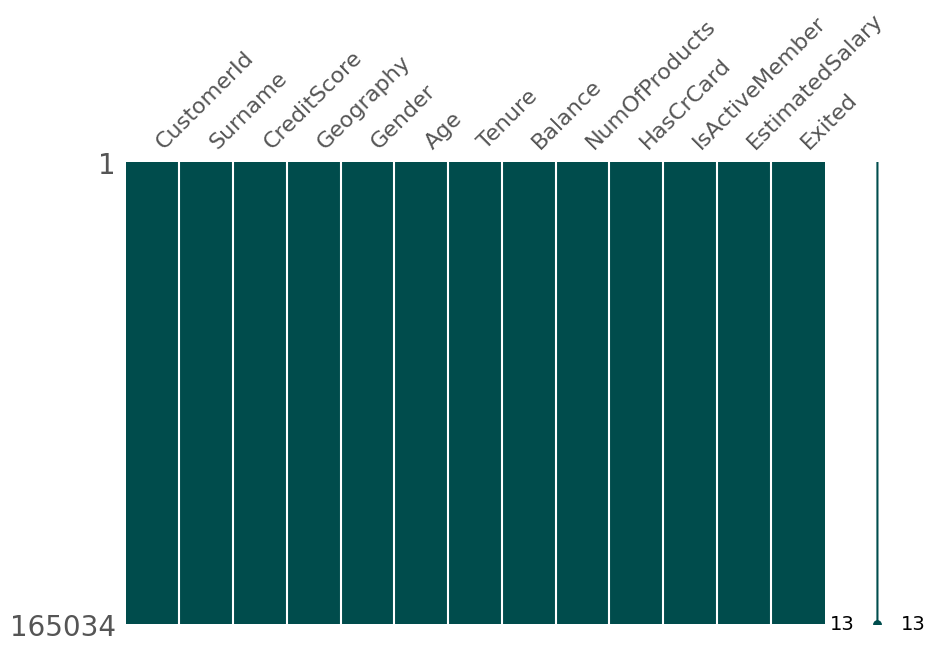

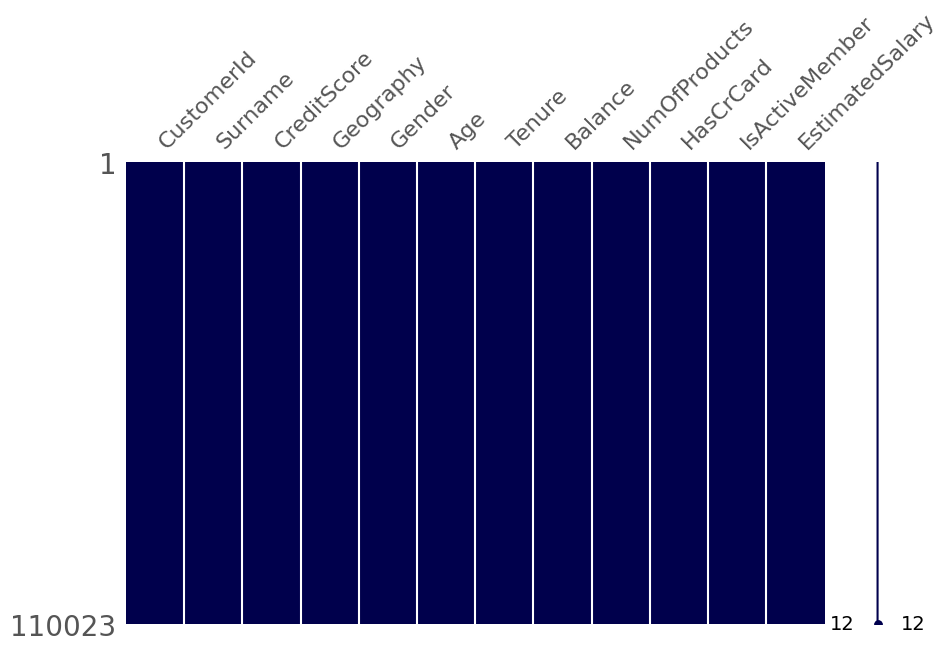

In [25]:
# 欠損値の有無を可視化する
print(msno.matrix(df=train, figsize=(10, 6), color=(0, .3, .3)))
print(msno.matrix(df=test, figsize=(10, 6), color=(0, 0, .3)))

元々欠損値がないデータ

## 重複データ

In [26]:
total = pd.concat([train.drop(target_col, axis=1), test], axis=0) # 目的変数を指定する
total.duplicated().sum()

0

## カラムごとのユニークな値を調べる

In [27]:
train[train.columns].nunique().sort_values(ascending=True)

Gender                 2
HasCrCard              2
IsActiveMember         2
Exited                 2
Geography              3
NumOfProducts          4
Tenure                11
Age                   71
CreditScore          457
Surname             2797
CustomerId         23221
Balance            30075
EstimatedSalary    55298
dtype: int64

### 目的変数

In [28]:
print(target_name +' Class labels:', np.unique(target))

['Exited'] Class labels: [0 1]


## データセットのプロット（分布）

### 密度関数（ヒストグラム）

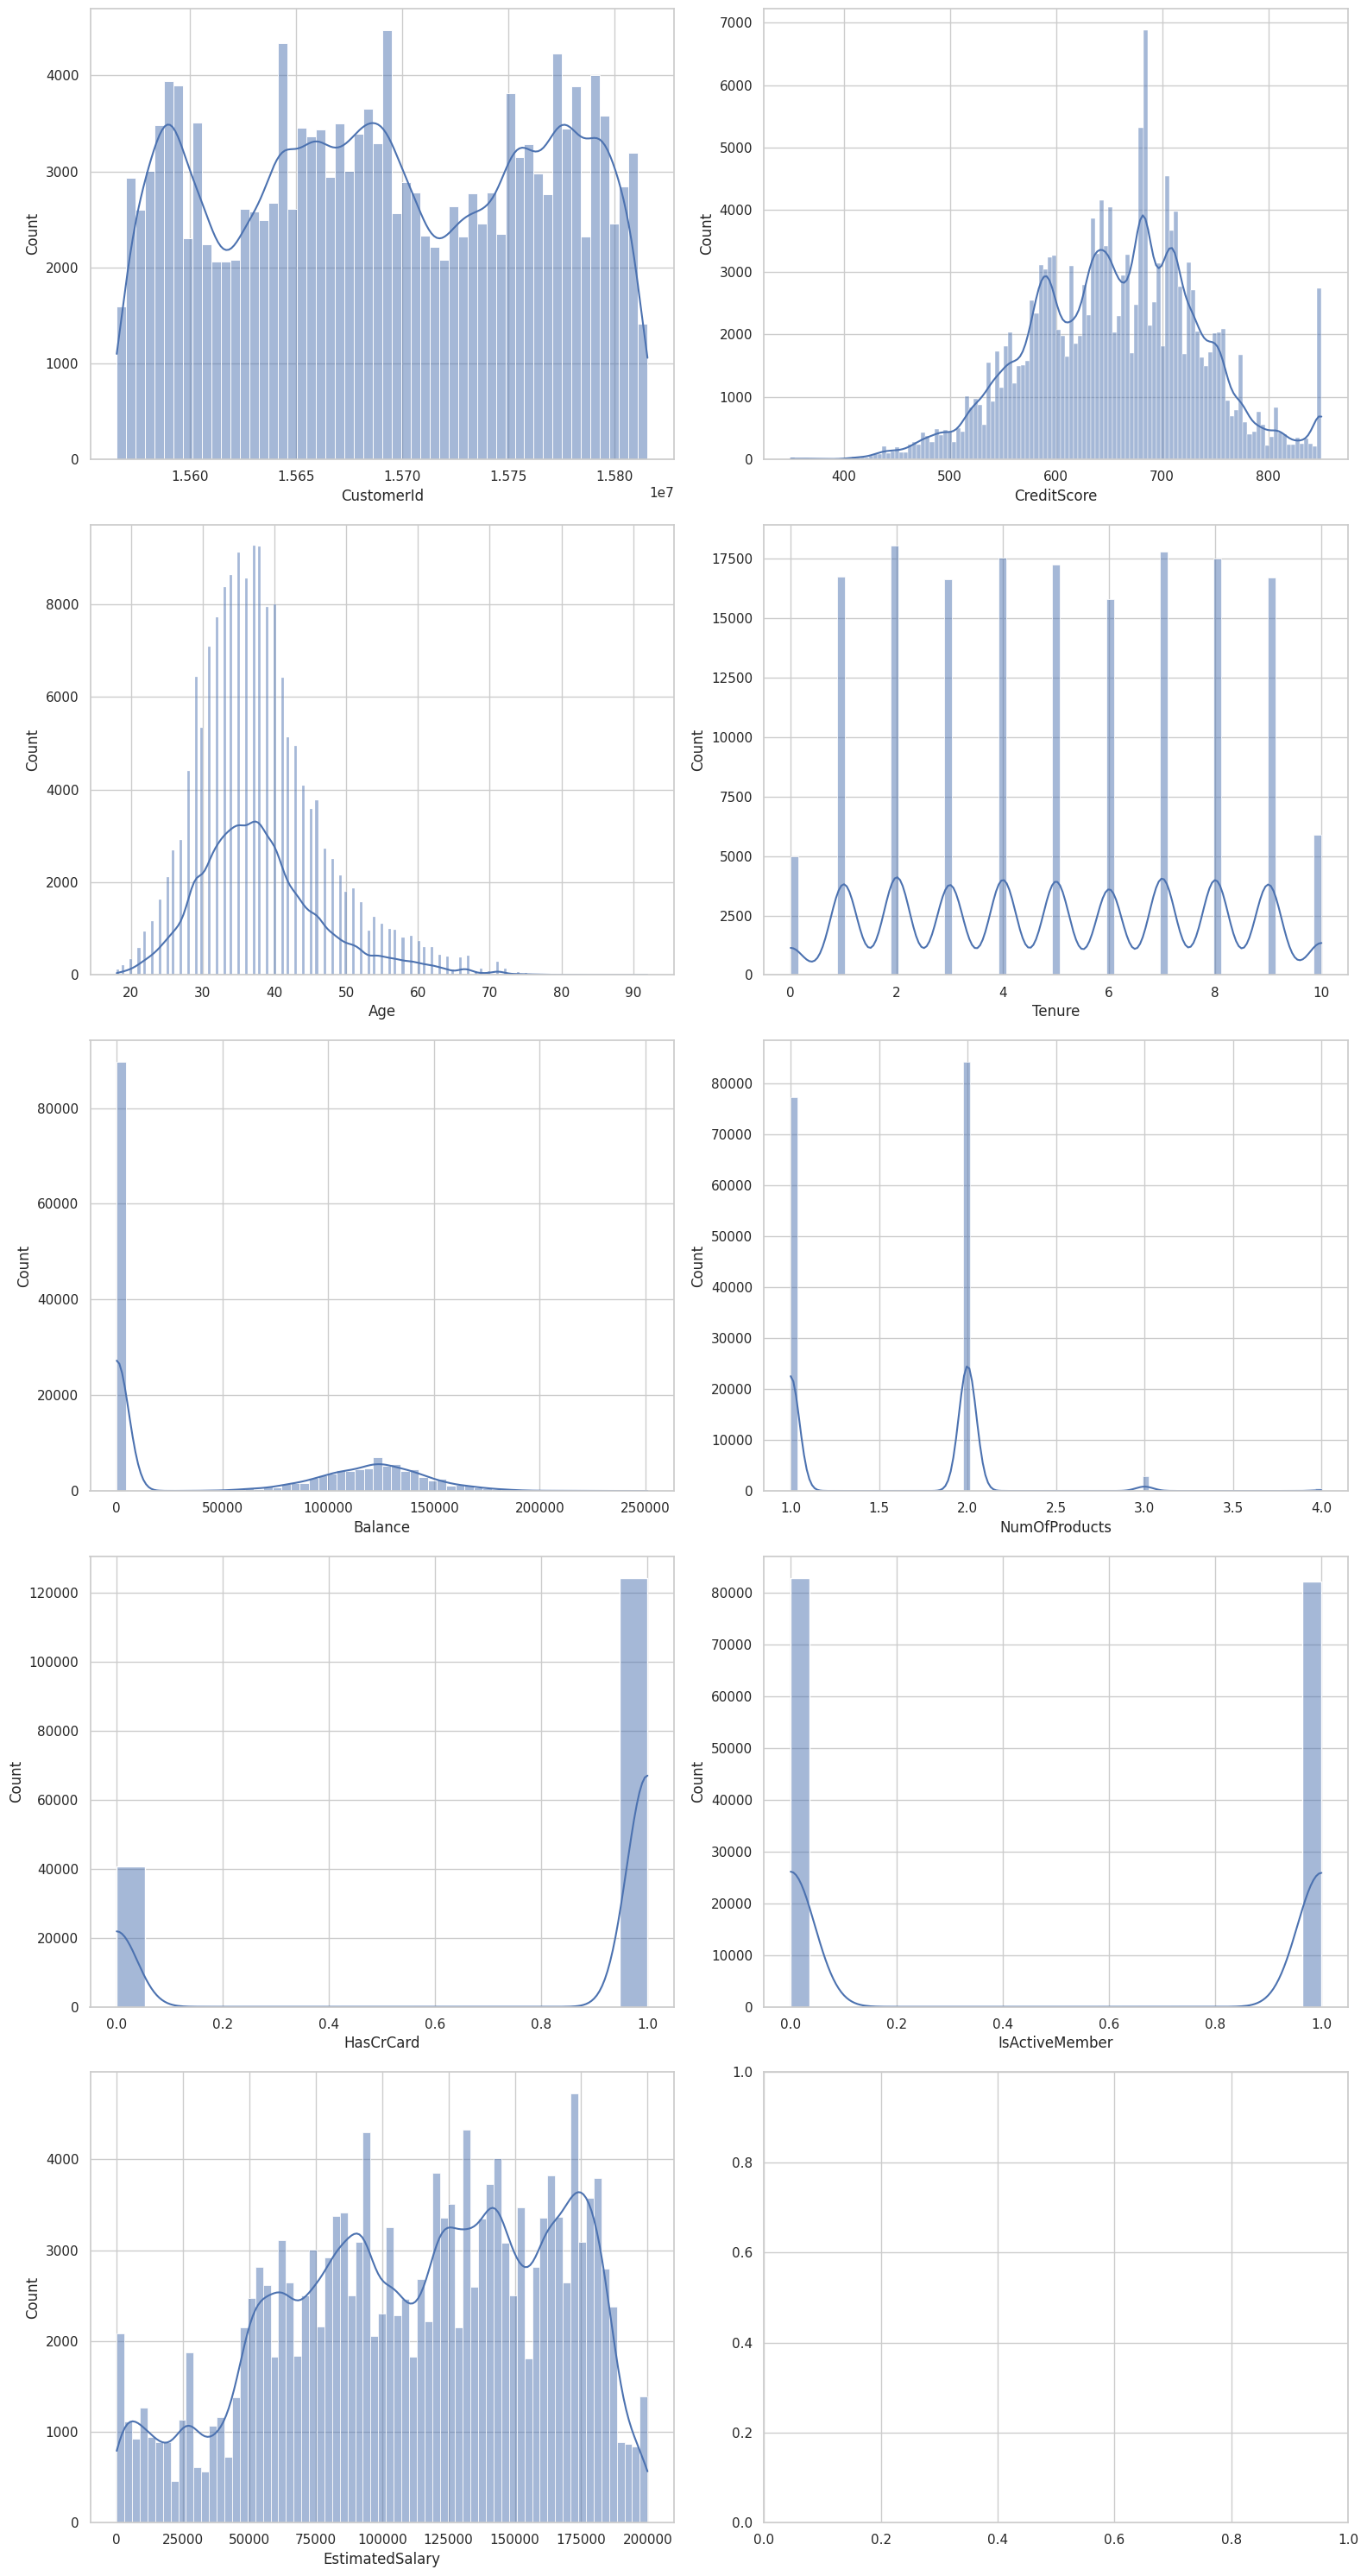

In [29]:
sns.set(style="whitegrid")

rows = (len(numerical_features) + 1) // 2
cols = 2
_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * cols, 6 * rows))

for i, feature_name in enumerate(numerical_features):
    row_idx, col_idx = divmod(i, cols)
    sns.histplot(data=train, x=feature_name, kde=True, ax=axes[row_idx, col_idx])

plt.tight_layout()

plt.show()

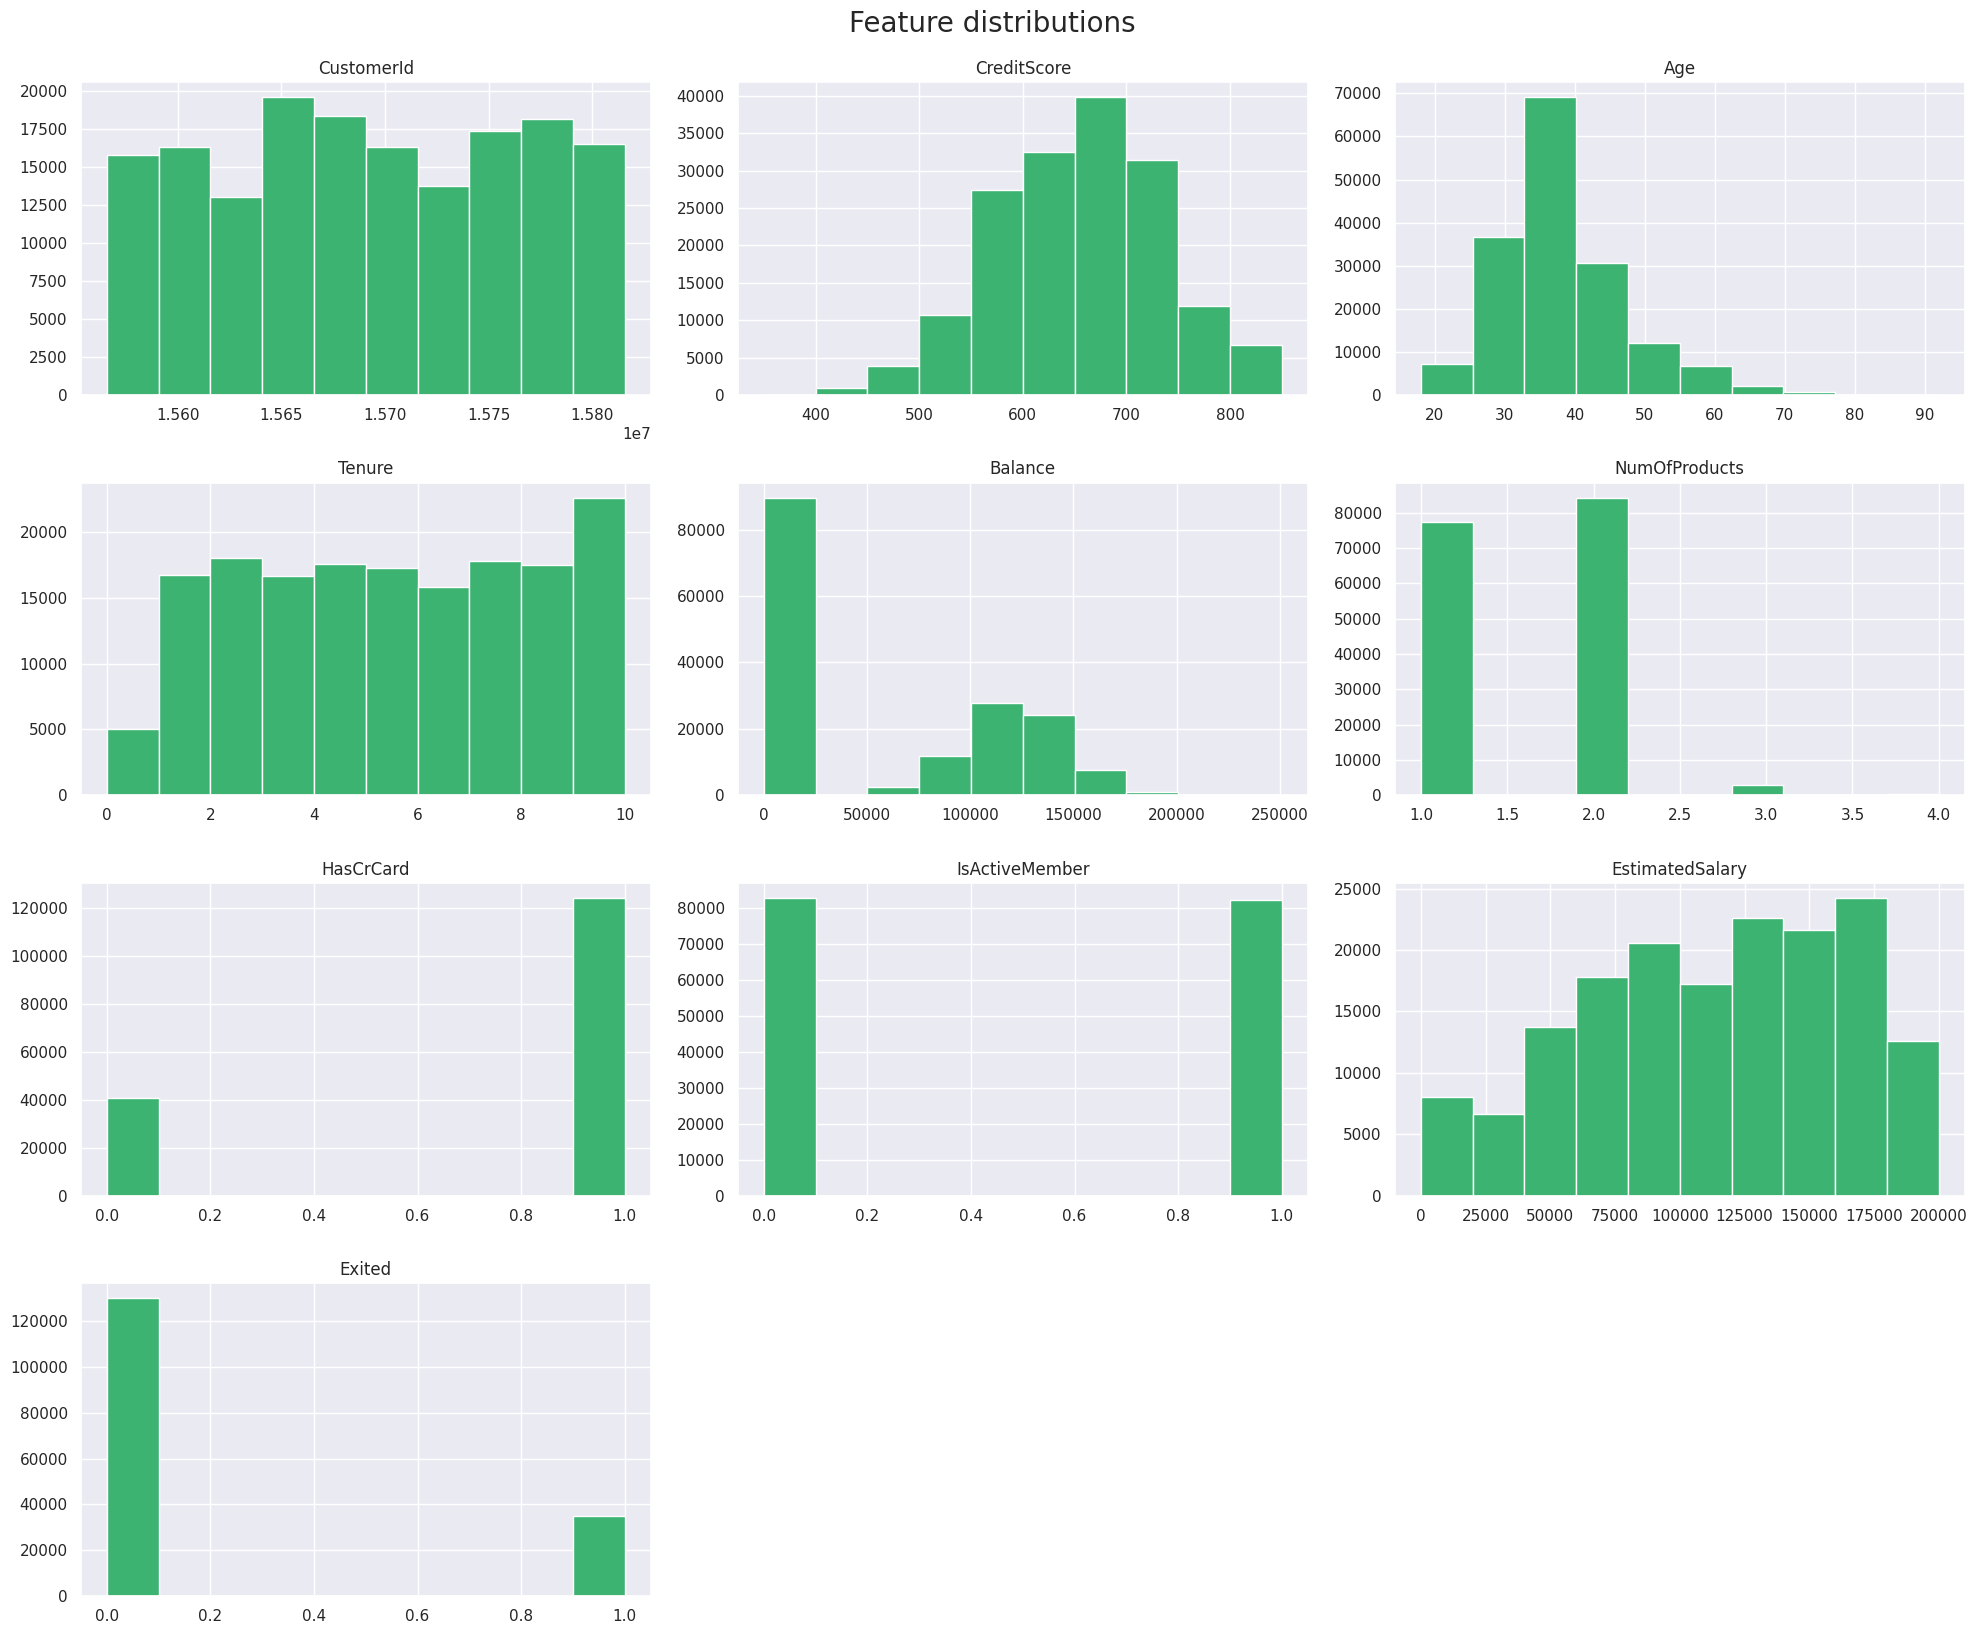

In [30]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

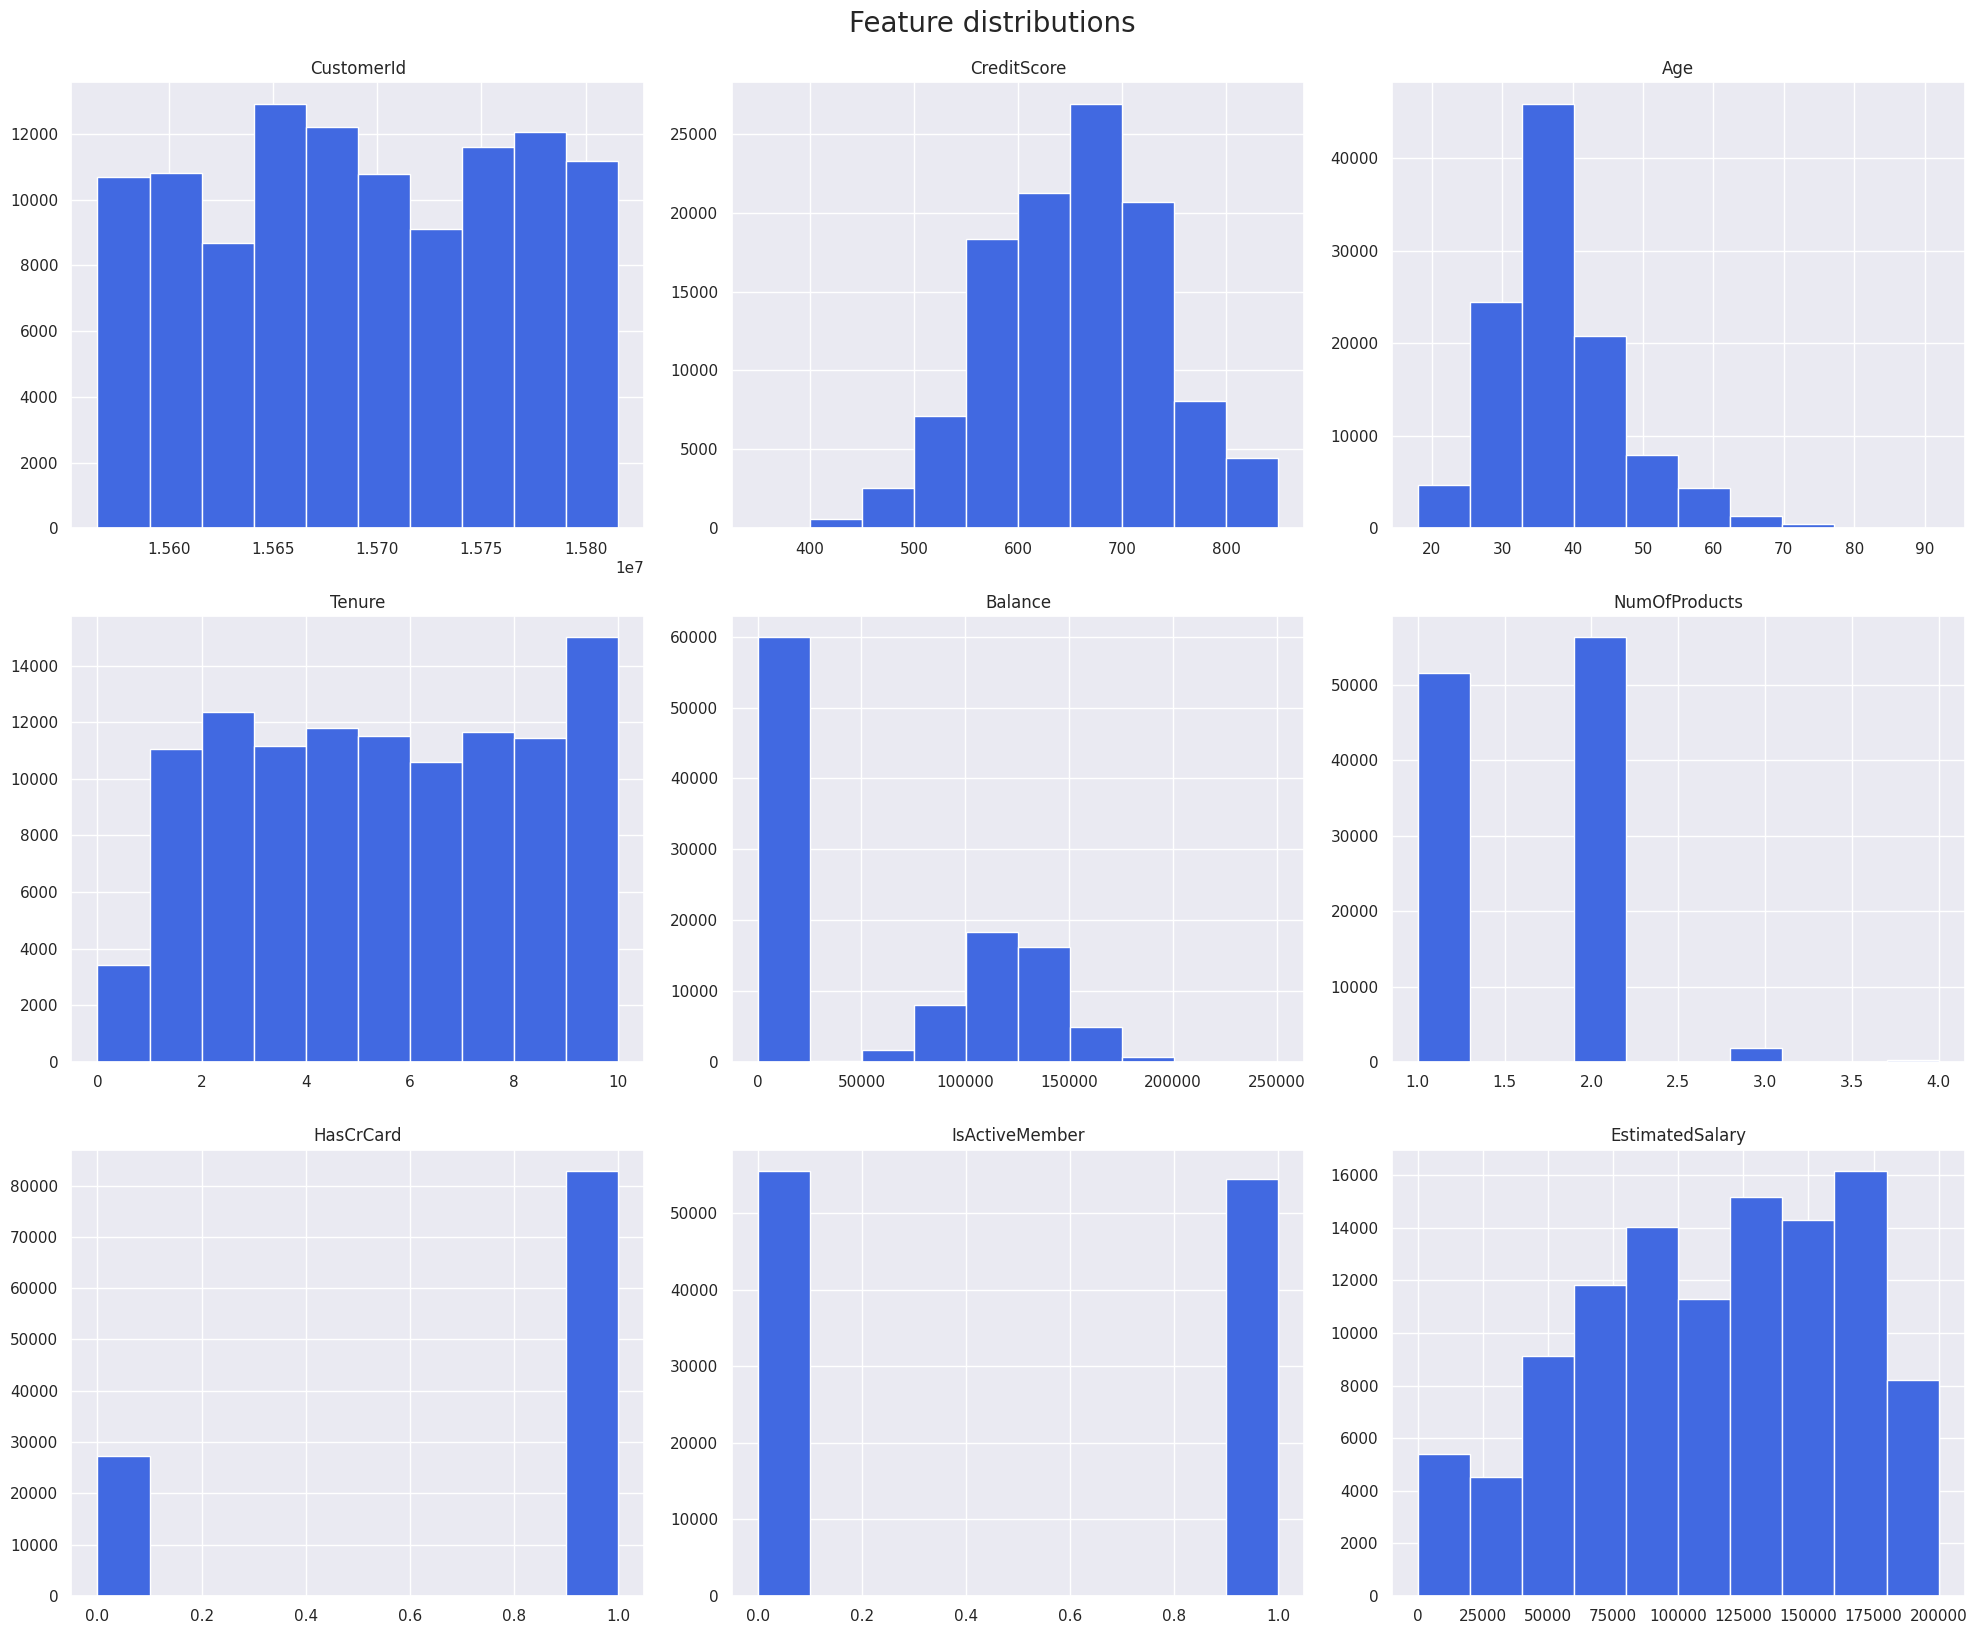

In [31]:
sns.set(rc={'figure.figsize': (20, 16)})
test.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

#### データの分布を可視化する

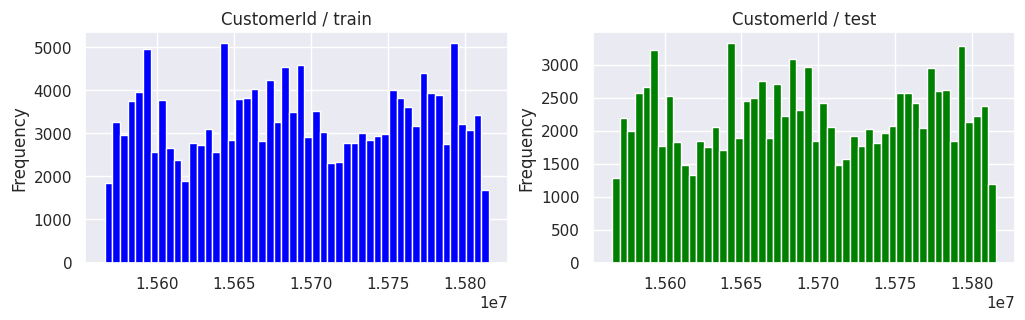

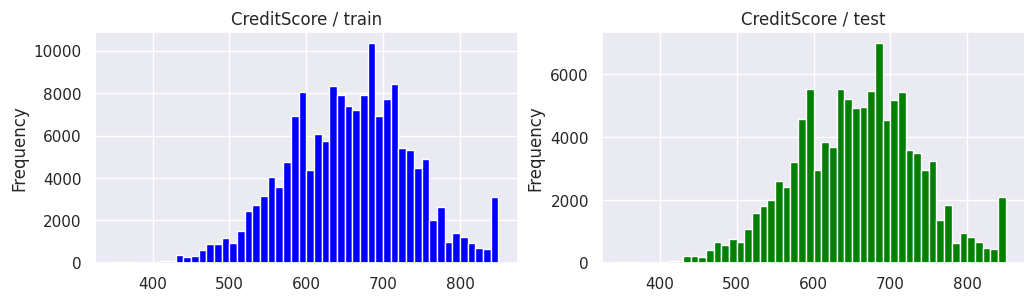

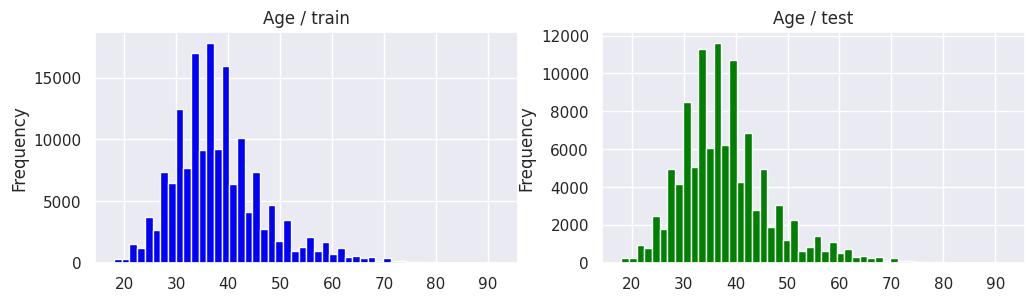

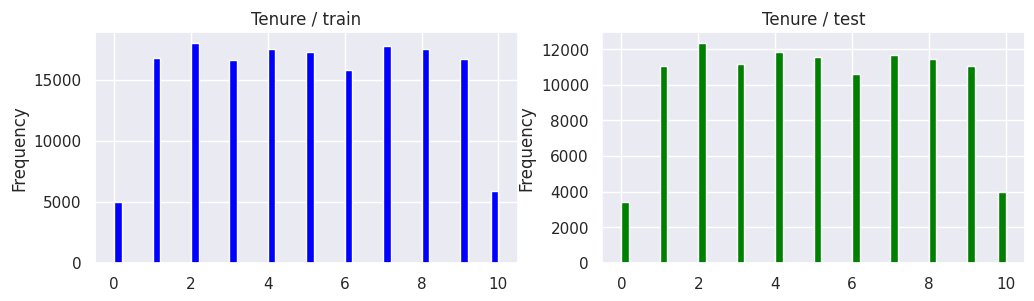

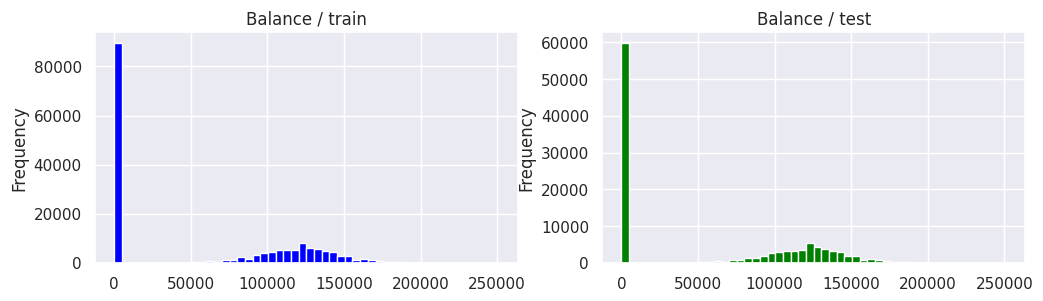

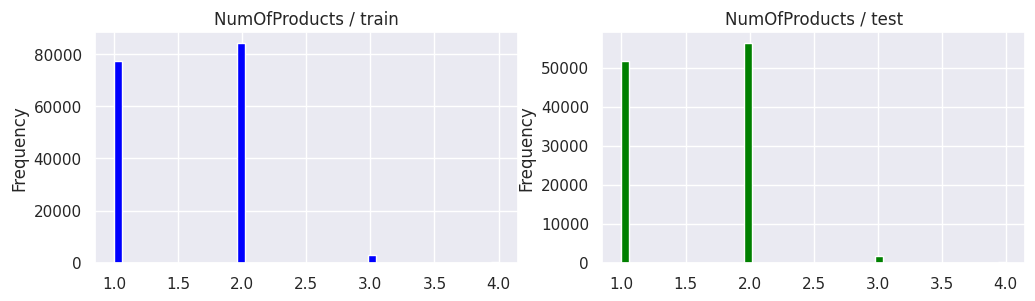

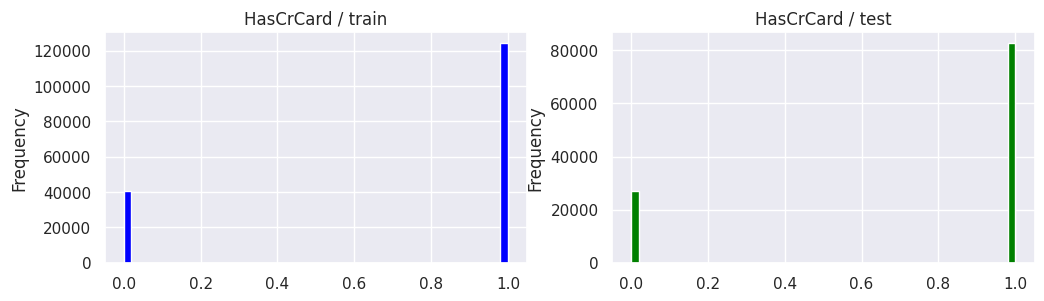

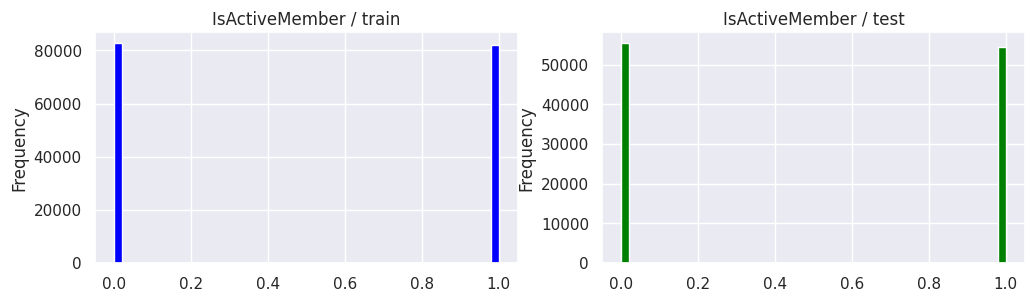

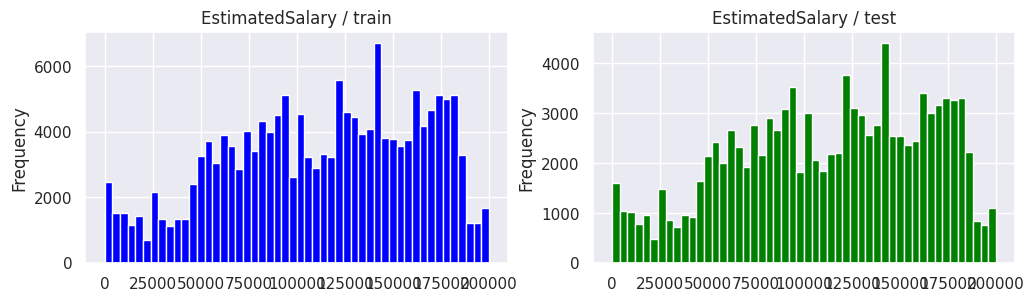

In [32]:
feature = train[numerical_features]

for feat in feature:
    plt.figure(figsize=(12, 3))
    ax1 = plt.subplot(1, 2, 1)
    train[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    ax2 = plt.subplot(1, 2, 2, sharex=ax1)
    test[feat].plot(kind='hist', bins=50, color='green')
    plt.title(feat + ' / test')

    plt.show()

#### データを対数変換する

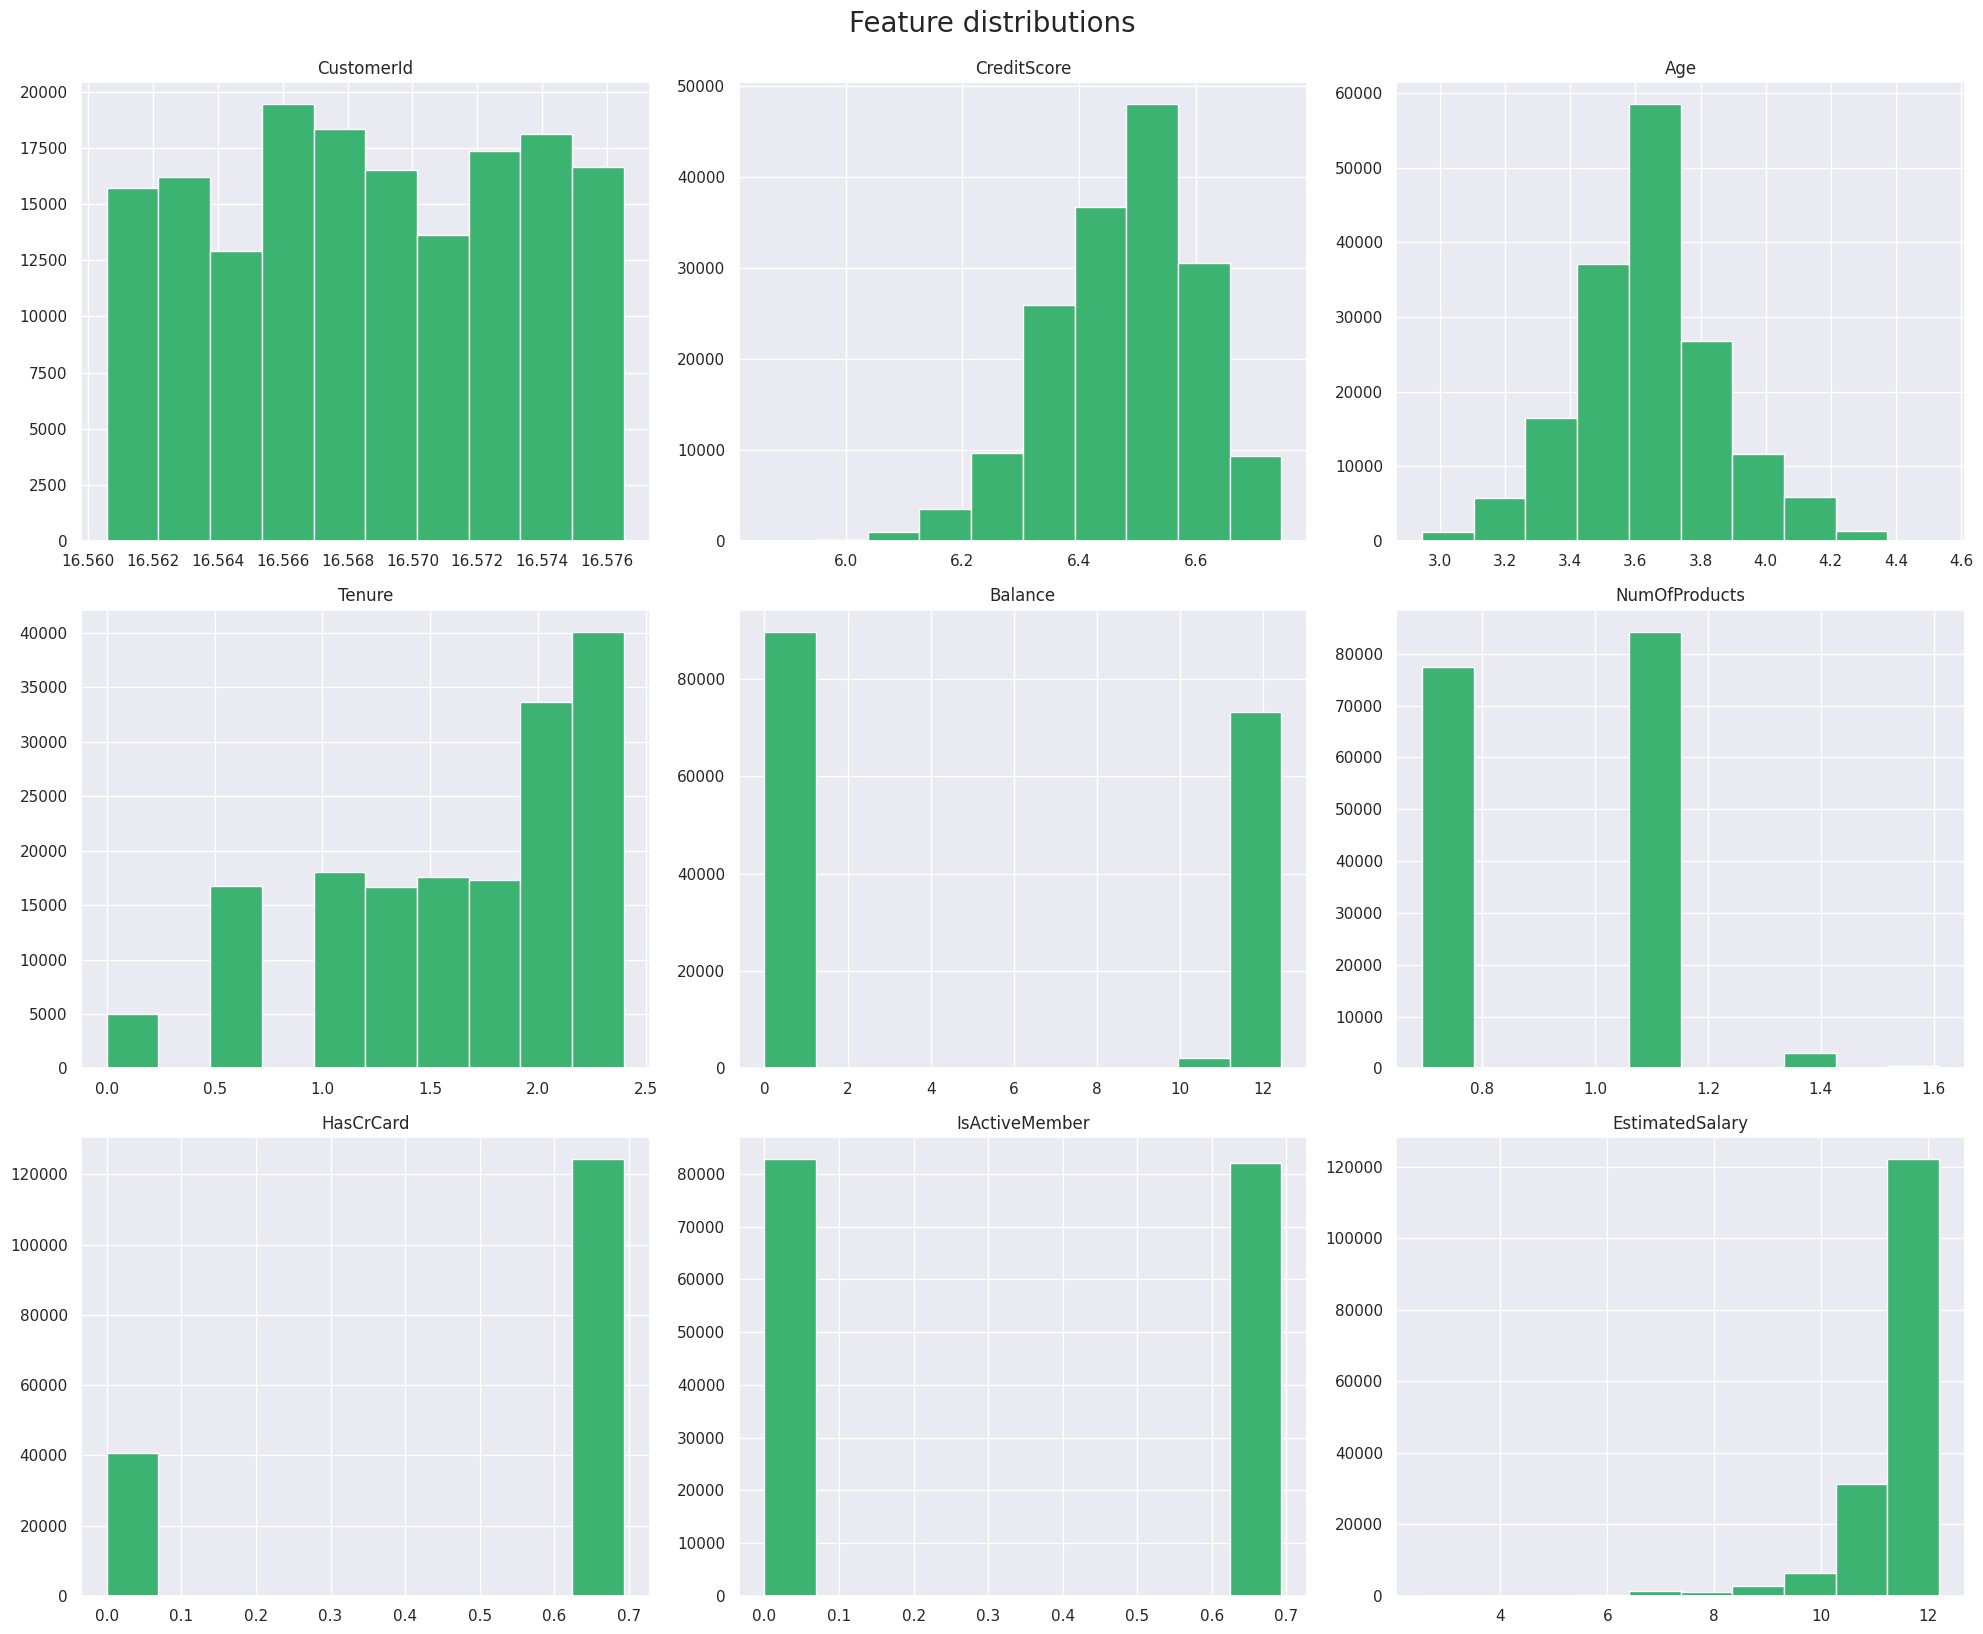

In [33]:
# 訓練データをX(説明変数)とy（目的変数）に分割する
X = train[numerical_features]
y = target

for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log(x + 1))

X.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

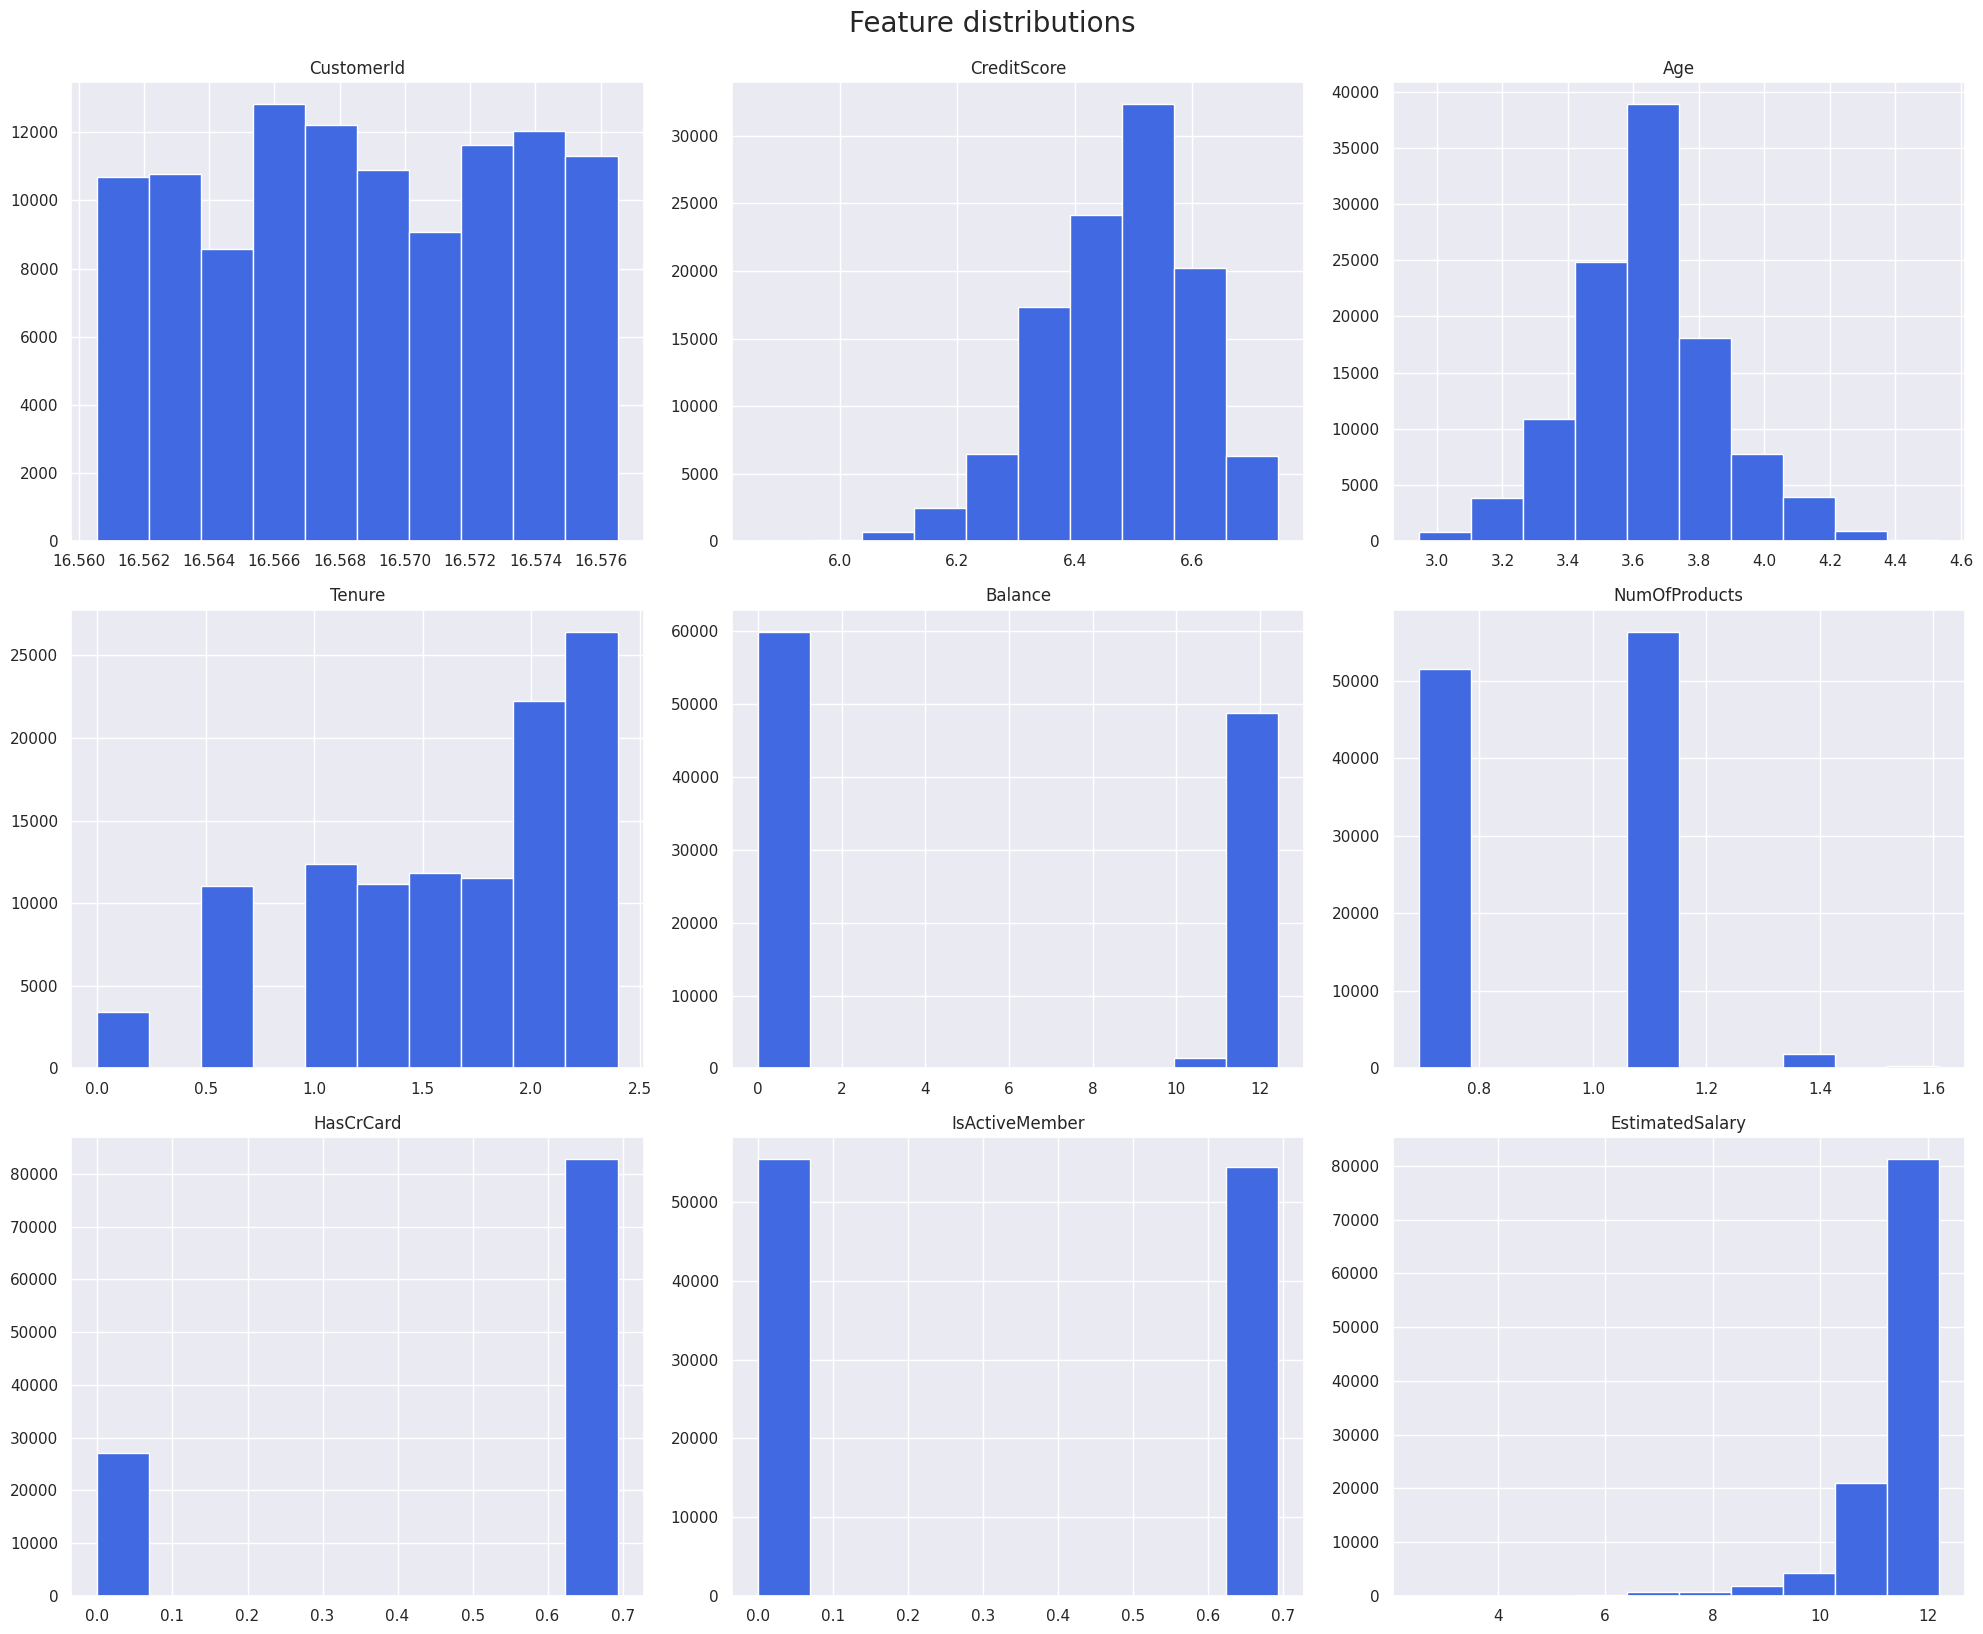

In [34]:
# テストデータも変換する
test_log = test[numerical_features]
for column in test_log.columns.tolist():
    test_log[column] = test_log[column].apply(lambda x: np.log(x + 1))

test_log.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

* 一部の説明変数において分布が確認しやすくなった

##### 数値型の説明変数の分布

カーネル密度推定（KDE: Kernel Density Estimation）
- 実データから、正規分布曲線のように下部の面積が1となるような連続した曲線（確率密度関数）を推定する

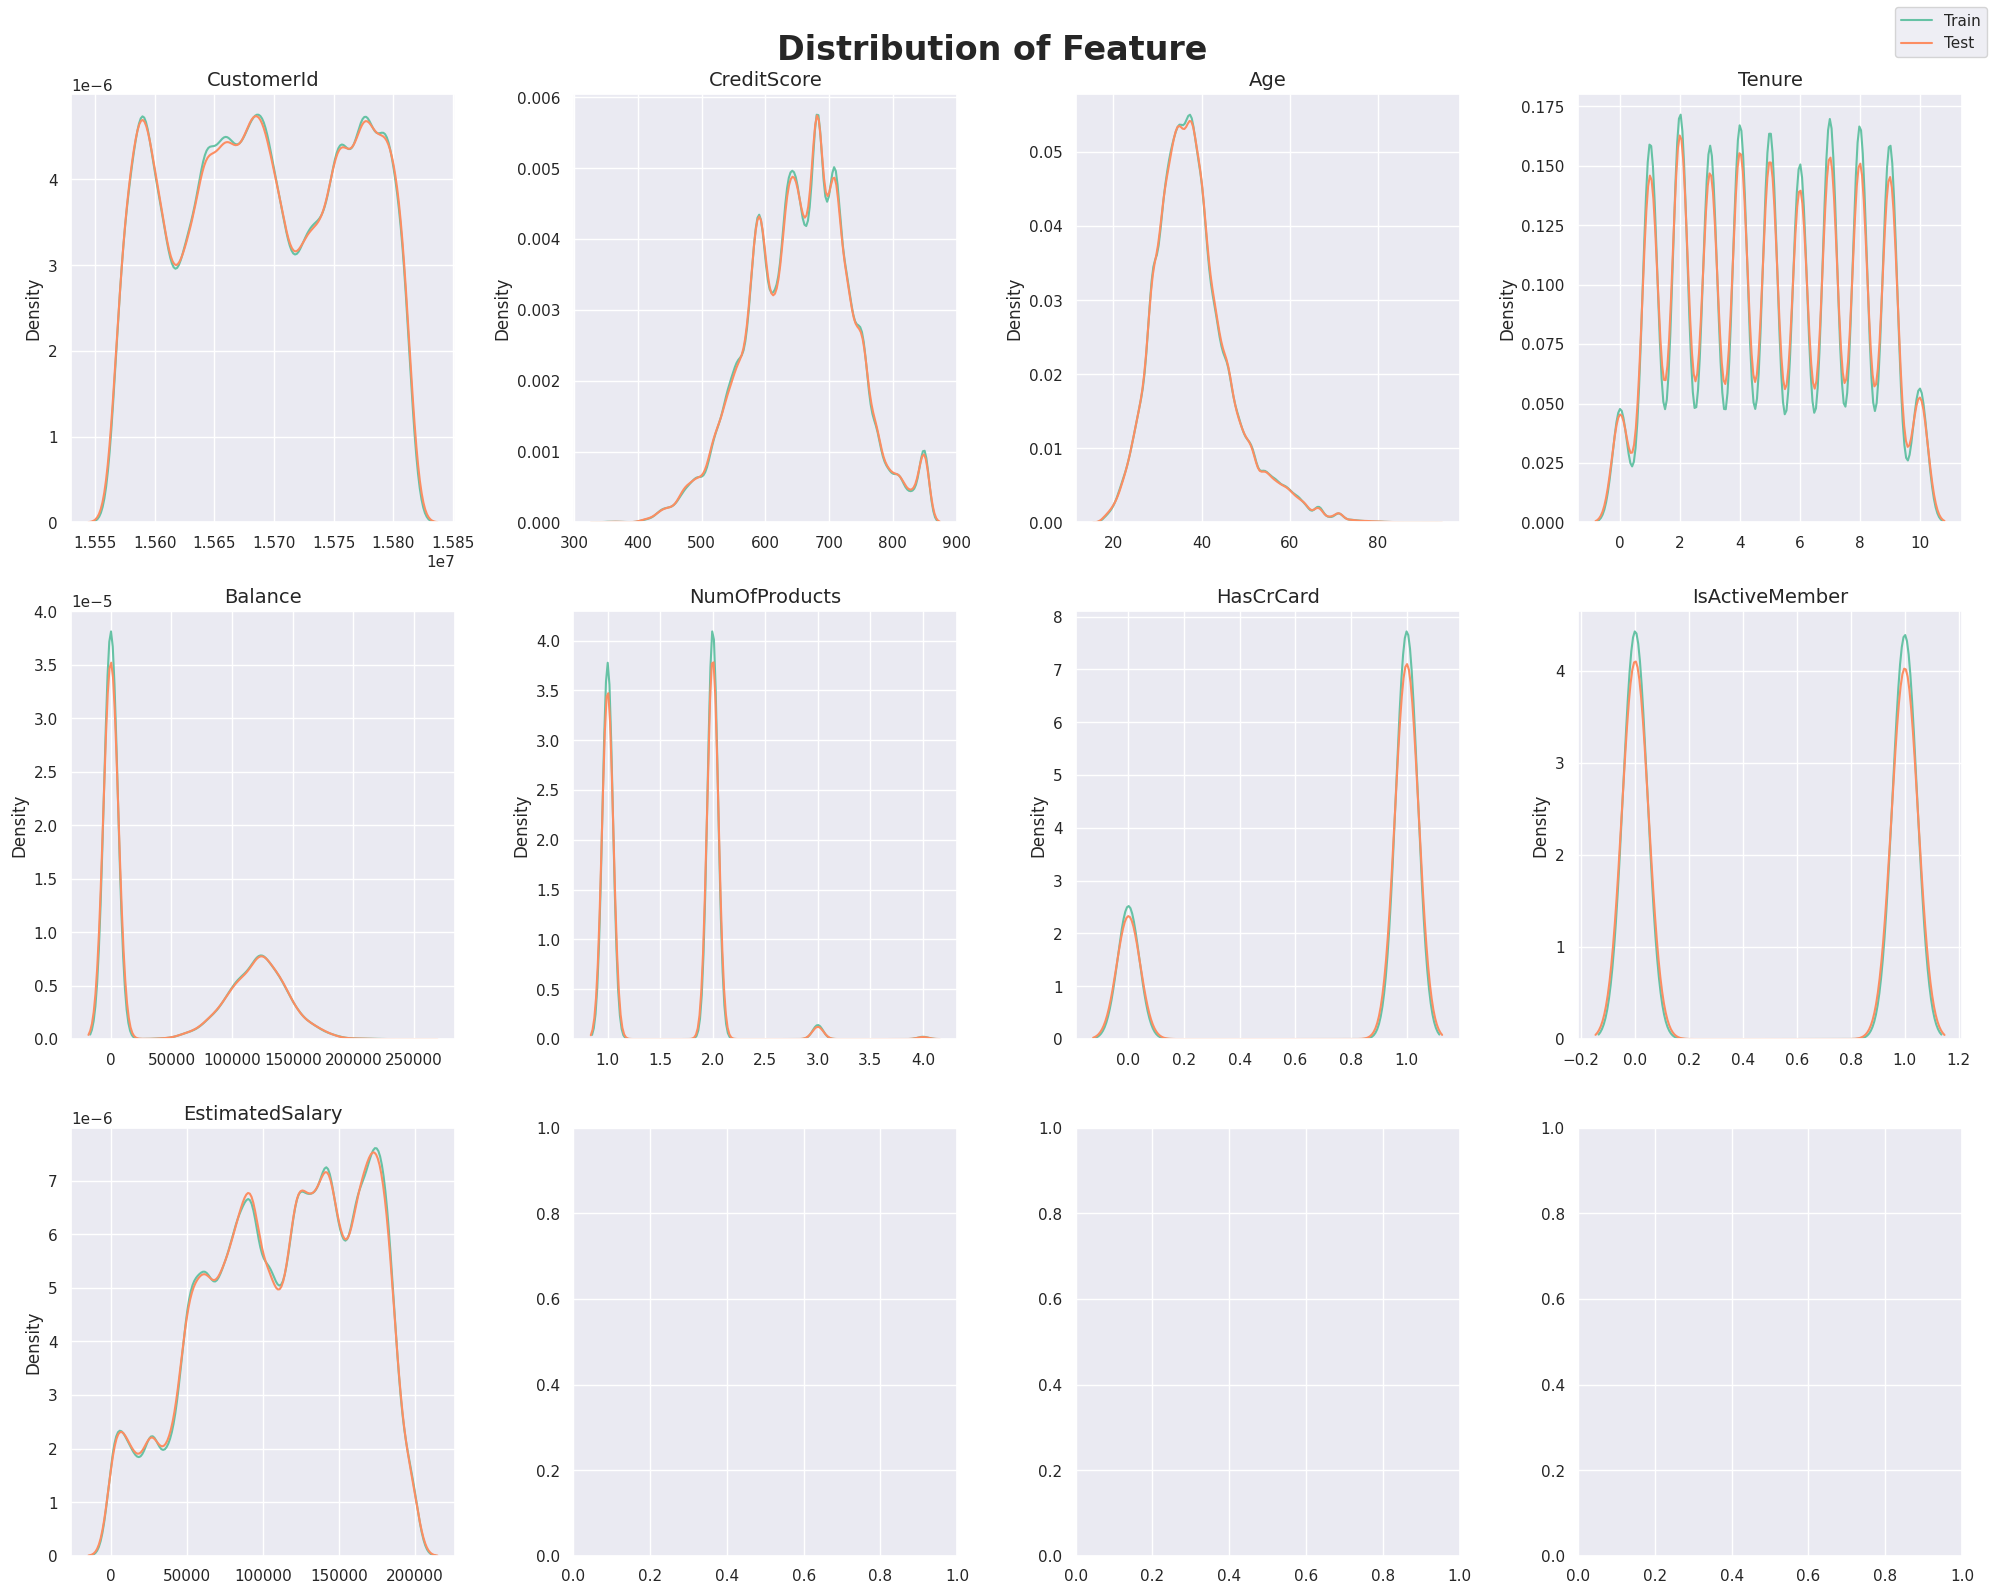

In [35]:
fig, ax = plt.subplots(len(numerical_features) // 4 + 1, 4)
ax = ax.flatten()
pal2 = sns.color_palette("Set2")
for i, column in enumerate(numerical_features):
    sns.kdeplot(train[column], ax=ax[i], color=pal2[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal2[1], warn_singular=False)

    ax[i].set_title(f'{column}', size=14)
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature', fontsize=24, fontweight='bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

#### Adversarial Validation(敵対性の検証)

- Adversarial Validation(敵対性の検証)の目的
    - 訓練用のデータセットとテスト用データセットの間で値の分布に差があるかないかを検証すること
- もしもしこの検証の結果得られるROC-AUCスコアが0.5に近いようなら、二つのデータセットは同じ分布を持っていると考えていい
    - しかしその値が0.5から離れているようなら、分布が同様とは言えない

- 信頼できるCV（Cross-validation）スコアは同様の分布を持つデータセットからのみ取得されるため、あらかじめCVスコアが信頼できることを確認しておくためこの検証が必要

In [36]:
# 時間がかかるため、割愛
# def adversarial_validation(dataset_1=train, dataset_2 = test, label='Train-Test'):
#     adv_train = dataset_1.drop(target_col, axis=1)
#     adv_test = dataset_2.copy()

#     adv_train['is_test'] = 0
#     adv_test['is_test'] = 1

#     adv = pd.concat([adv_train, adv_test], ignore_index=True)
#     adv_shuffled = adv.sample(frac=1)
#     adv_X = adv_shuffled.drop('is_test', axis=1)
#     adv_y = adv_shuffled.is_test

#     skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#     val_scores = []
#     predictions = np.zeros(len(adv))

#     for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
#         adv_lr = make_pipeline(OneHotEncoder(cols=categorical_features), XGBClassifier(random_state=42))
#         adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])

#         val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:, 1]
#         predictions[val_idx] = val_preds
#         val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
#         val_scores.append(val_score)

#     fpr, tpr, _ = roc_curve(adv['is_test'], predictions)

#     plt.figure(figsize=(10, 10), dpi=300)
#     sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
#     sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
#     plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight='bold', size=17)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.show()

# adversarial_validation()

## 円グラフと棒グラフ

### 円グラフと棒グラフ（目的変数）

Exited
0    130113
1     34921
Name: count, dtype: int64


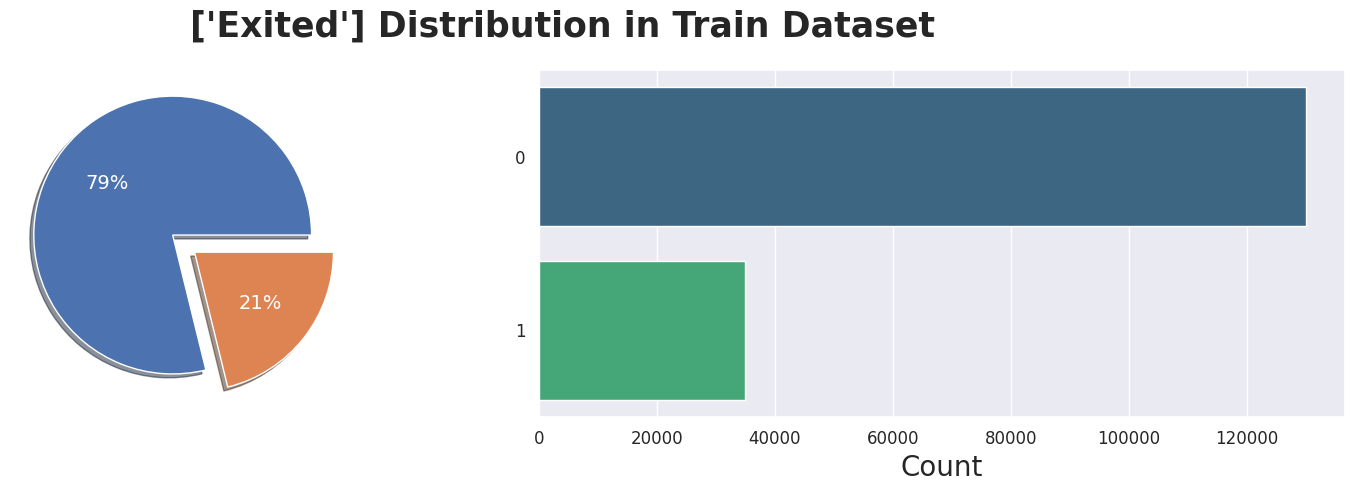

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax = ax.flatten()

ax[0].pie(
    target.value_counts(),
    shadow=True,
    explode=[.1 for i in range(target.nunique())],
    autopct='%1.f%%',
    textprops={'size': 14, 'color':'white'}
)

sns.countplot(data=train, y=target_col, ax=ax[1], palette='viridis', order=train[target_col].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize=12)
ax[1].set_xlabel('Count', fontsize=20)
ax[1].set_ylabel(None)
plt.xticks(fontsize=12)

fig.suptitle(target_name + ' Distribution in Train Dataset', fontsize=25, fontweight='bold')
plt.tight_layout()

# 目的変数を数える
print(f'{train[target_col].value_counts()}') # 目的変数を指定する

カテゴリ型変数の分布

In [50]:
# fig, ax = plt.subplots(6, 2, figsize=(16, 25))

# for i, column in enumerate(categorical_features):
#     ax[i][0].pie(
#         train[column].value_counts(),
#         shadow=True,
#         explode=[.1 for i in range(train[column].nunique())],
#         autopct='%1.f%%',
#         textprops={'size': 14, 'color': 'white'}
#     )

#     sns.countplot(data=train, y=column, ax=ax[i][1], palette='viridis', order=train[column].value_counts().index)
#     ax[i][1].yaxis.label.set_size(20)
#     plt.yticks(fontsize=12)
#     ax[i][1].set_xlabel('Count in Train', fontsize=15)
#     ax[i][1].set_ylabel(f'{column}', fontsize=15)
#     plt.xticks(fontsize=12)

# fig.suptitle('Distribution of Categorical Features in Train Dataset', fontsize = 25, fontweight = 'bold')
# plt.tight_layout()

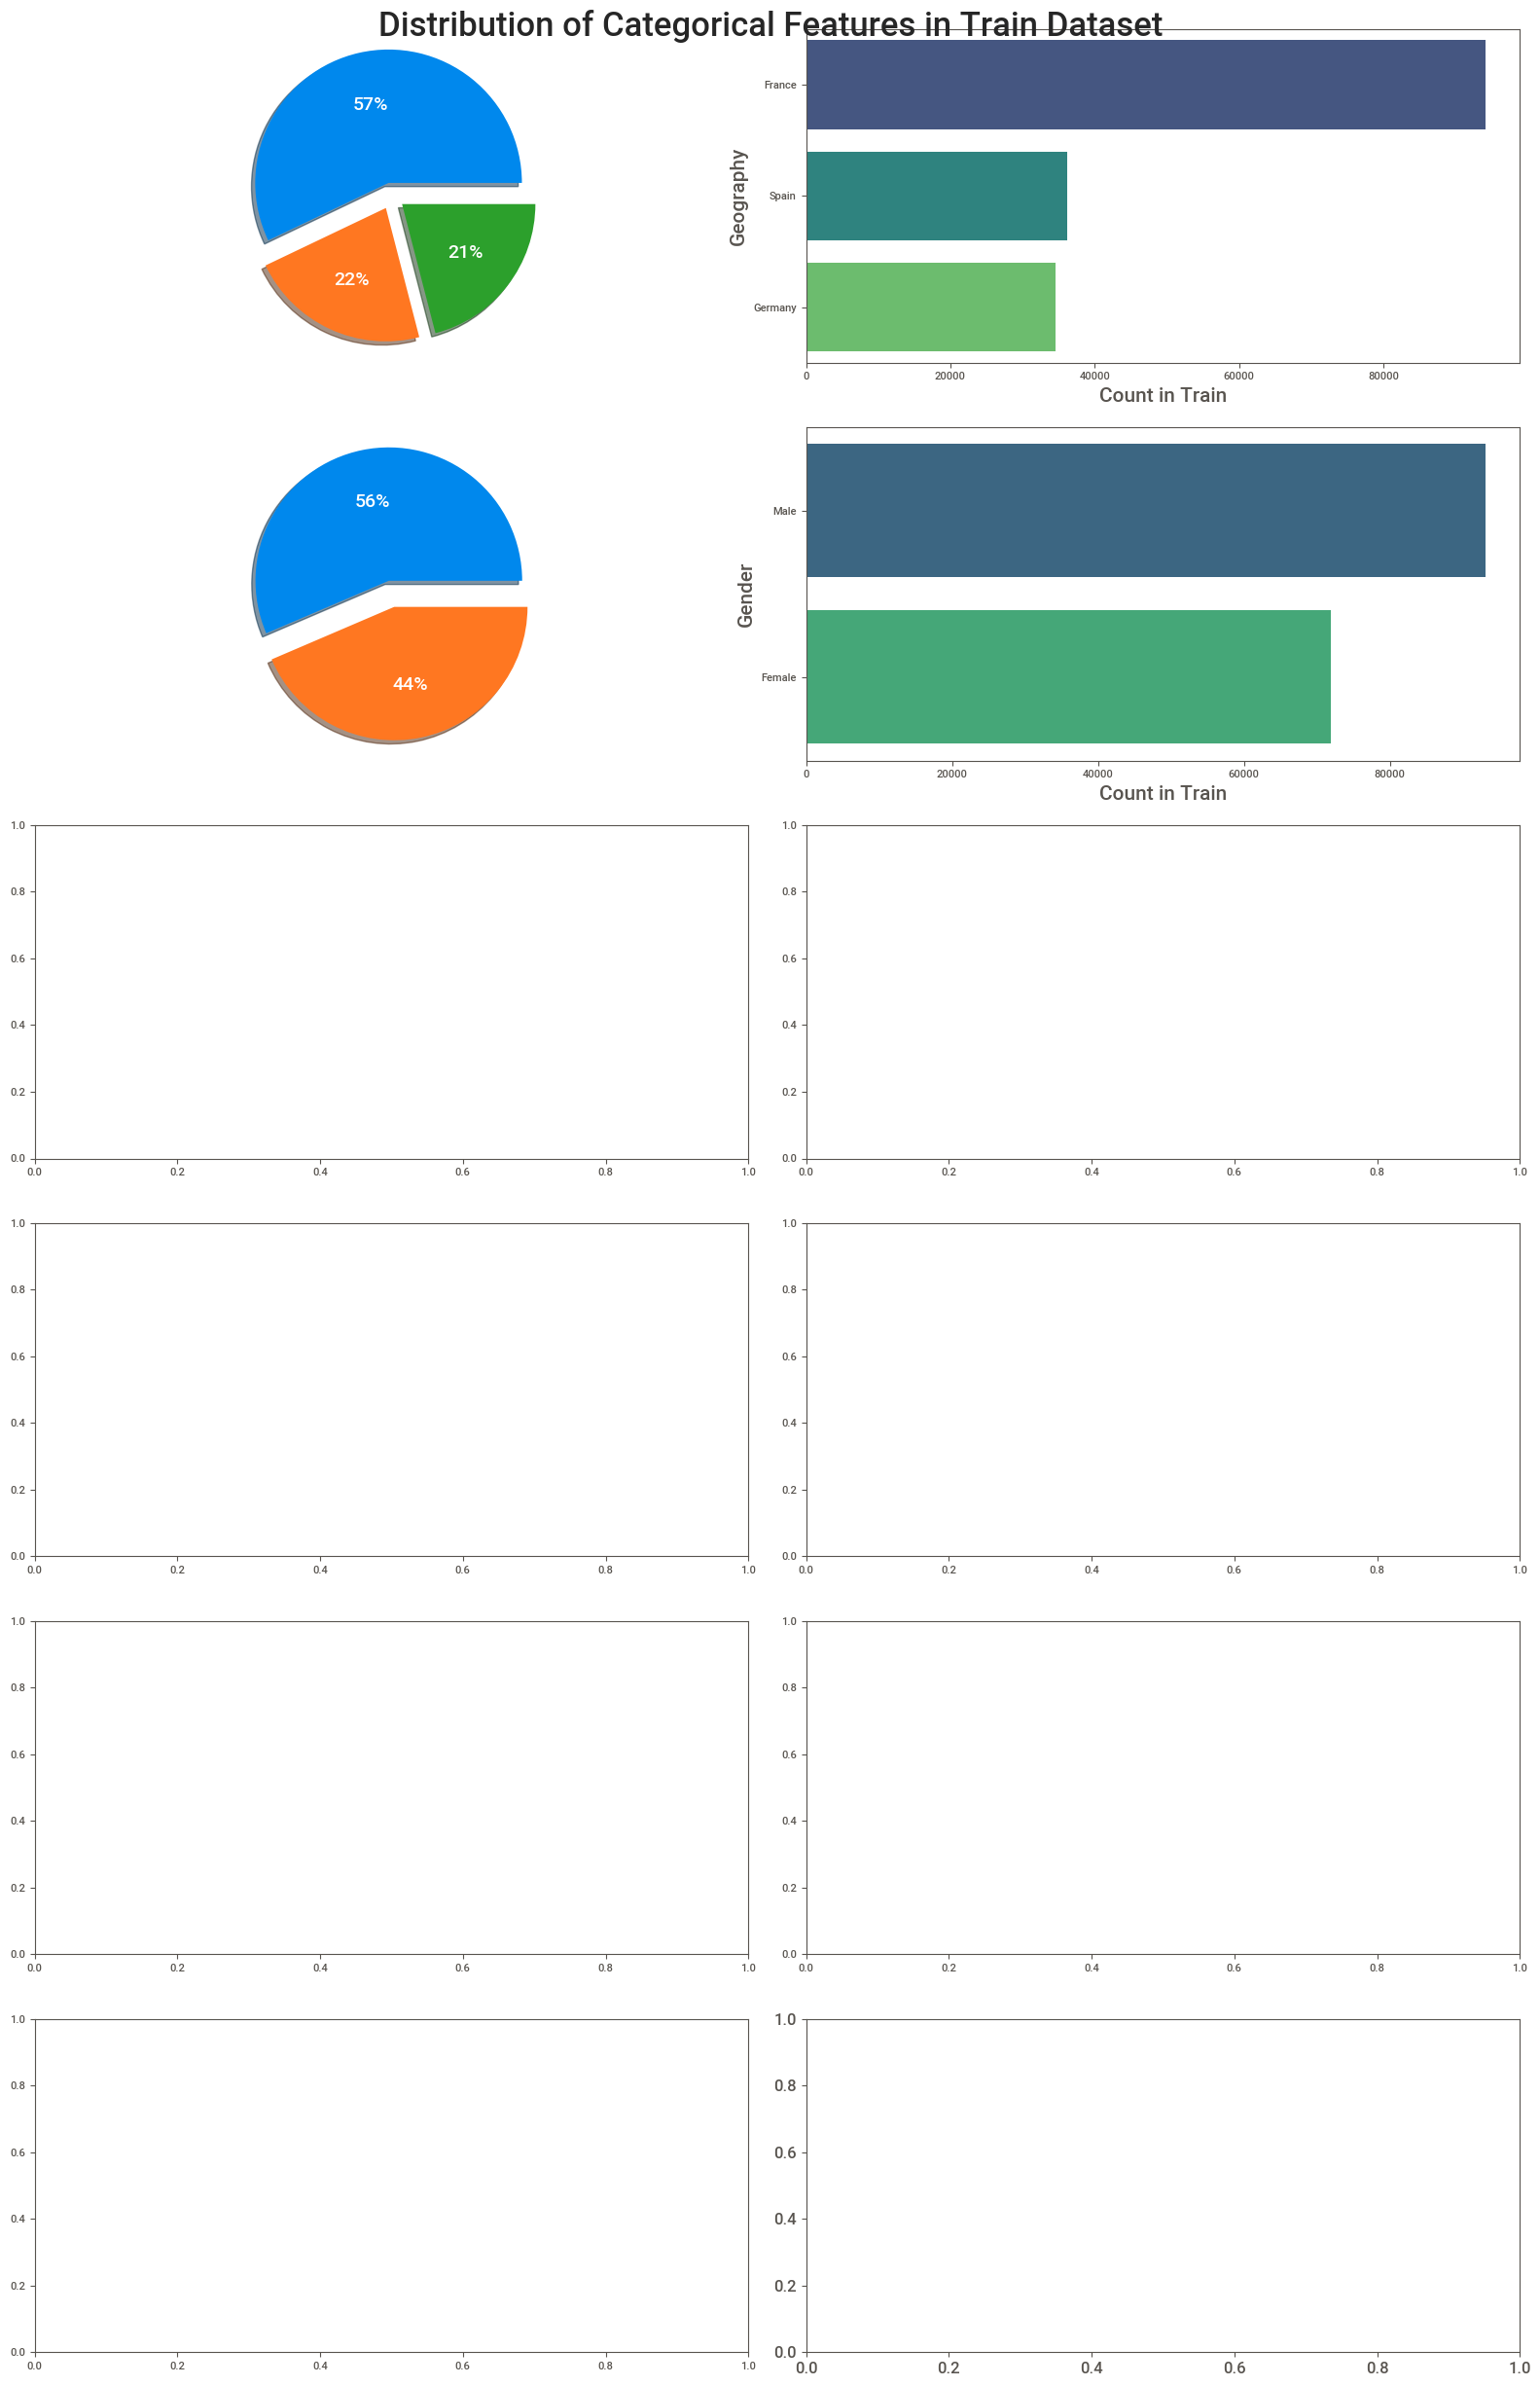

In [49]:
fig, ax = plt.subplots(6, 2, figsize=(16, 25))
categorical_features_show = categorical_features.drop('Surname')

for i, column in enumerate(categorical_features_show):
    ax[i][0].pie(
        train[column].value_counts(),
        shadow=True,
        explode=[.1 for i in range(train[column].nunique())],
        autopct='%1.f%%',
        textprops={'size': 14, 'color': 'white'}
    )

    sns.countplot(data=train, y=column, ax=ax[i][1], palette='viridis', order=train[column].value_counts().index)
    ax[i][1].yaxis.label.set_size(20)
    plt.yticks(fontsize=12)
    ax[i][1].set_xlabel('Count in Train', fontsize=15)
    ax[i][1].set_ylabel(f'{column}', fontsize=15)
    plt.xticks(fontsize=12)

fig.suptitle('Distribution of Categorical Features in Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

### 箱ひげ図

数値型の説明変数

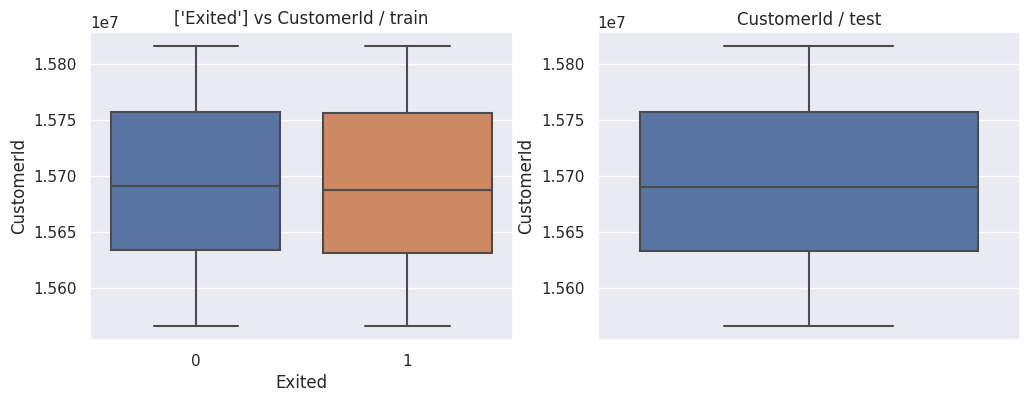

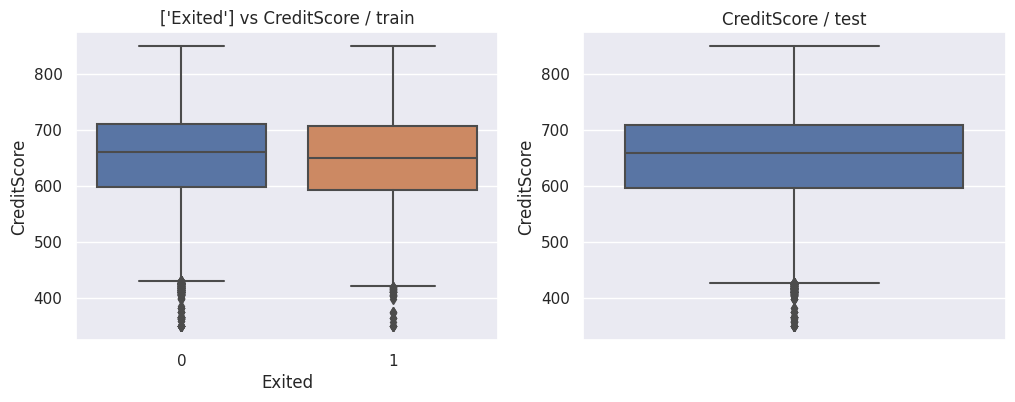

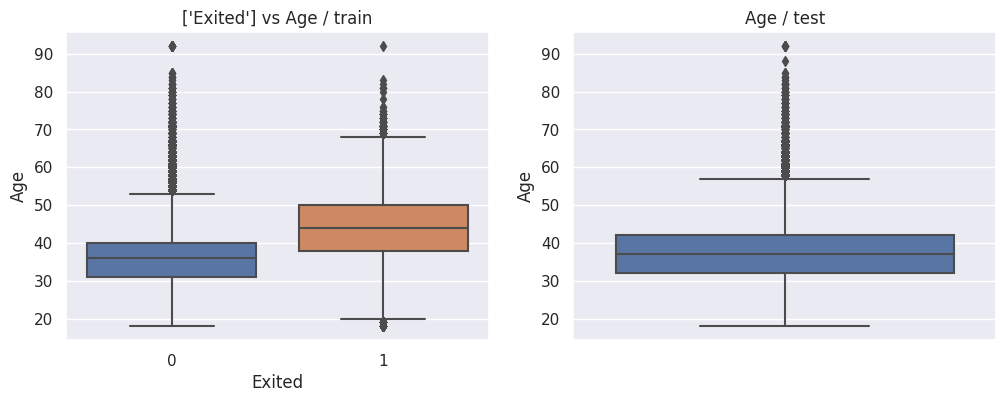

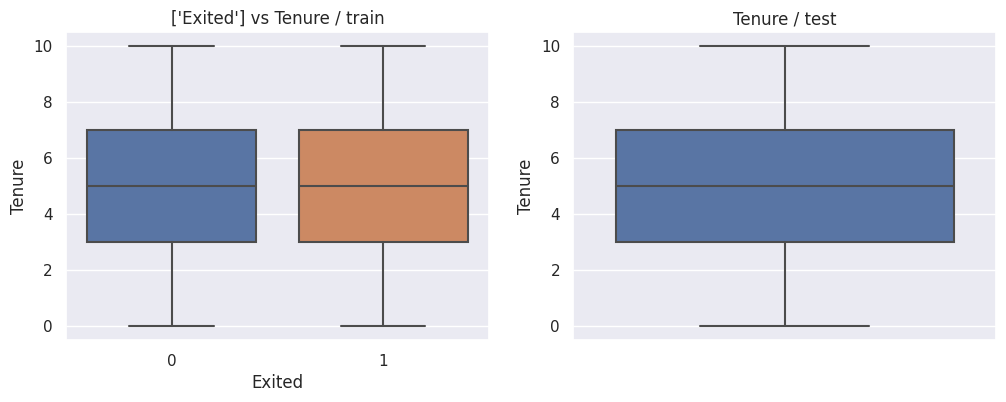

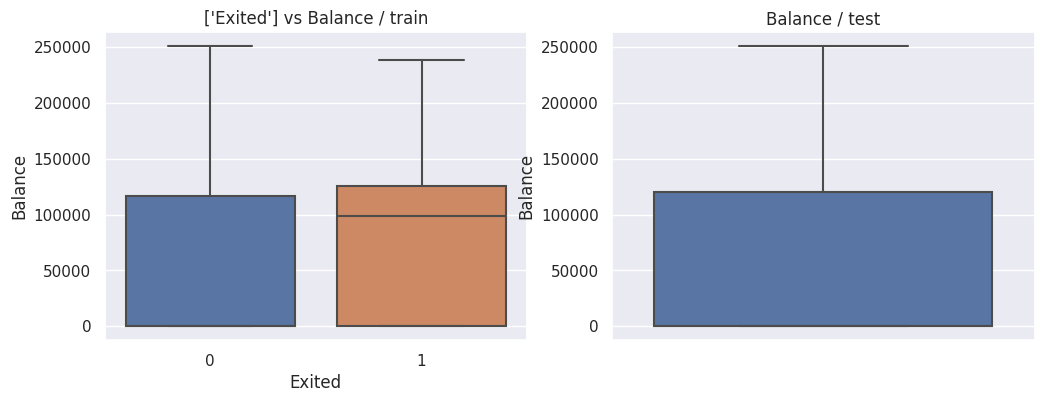

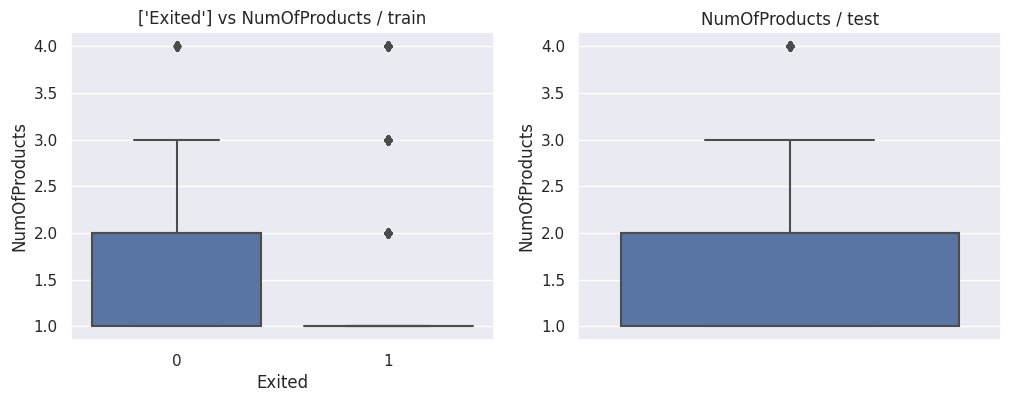

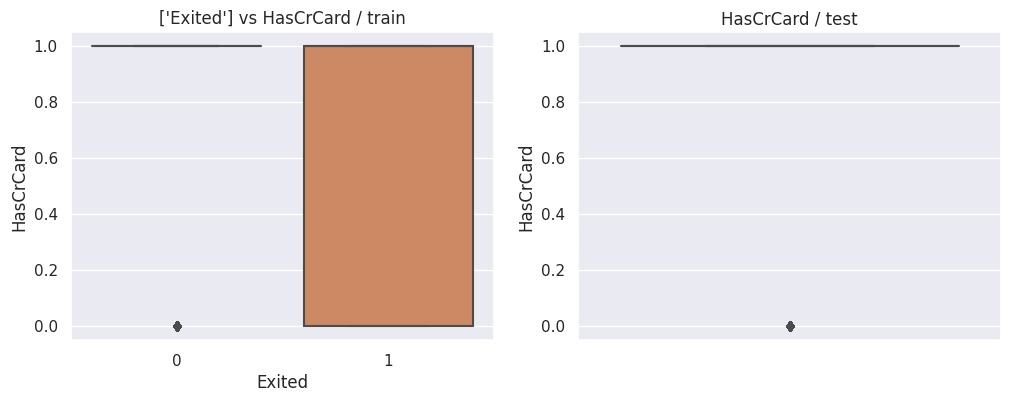

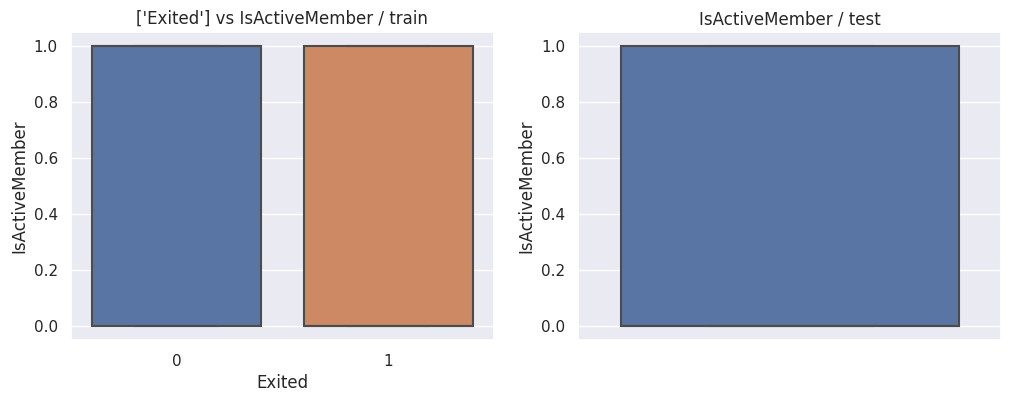

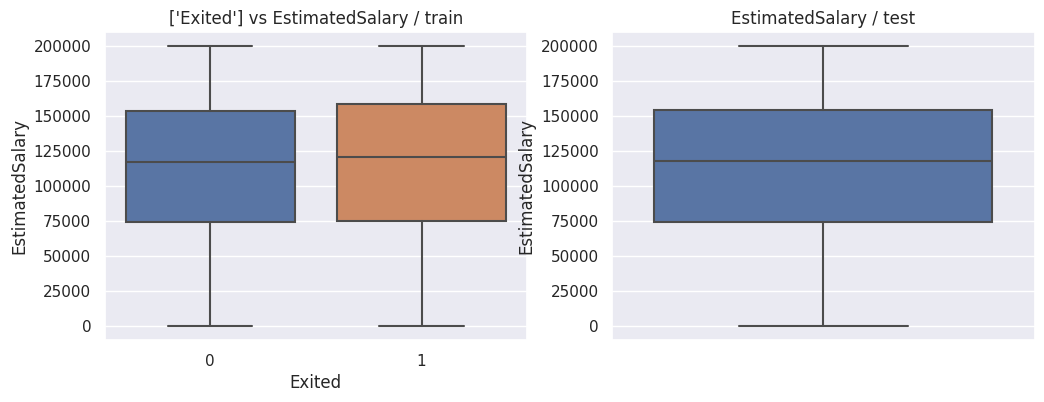

In [39]:
for feat in numerical_features:
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    sns.boxplot(data=train, x=target, y=feat)
    plt.title(target_name + ' vs ' + feat + ' / train')
    x1 = plt.subplot(1, 2, 2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()

#### 箱ひげ図（目的変数）

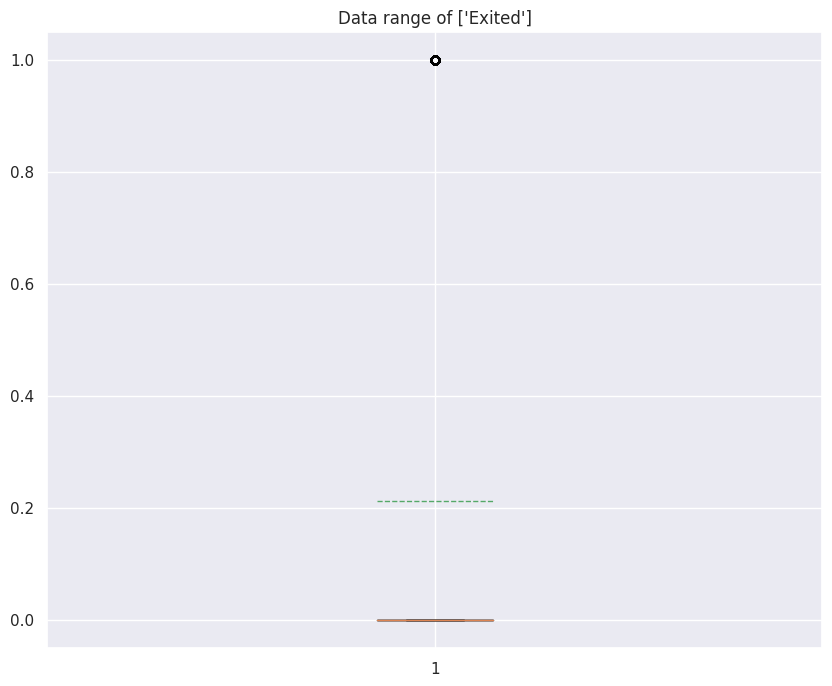

In [40]:
# データの範囲を調べる
plt.figure(figsize=(10, 8))
plt.boxplot(target, showmeans=True, meanline=True)
plt.title('Data range of ' + target_name)
plt.grid(True)

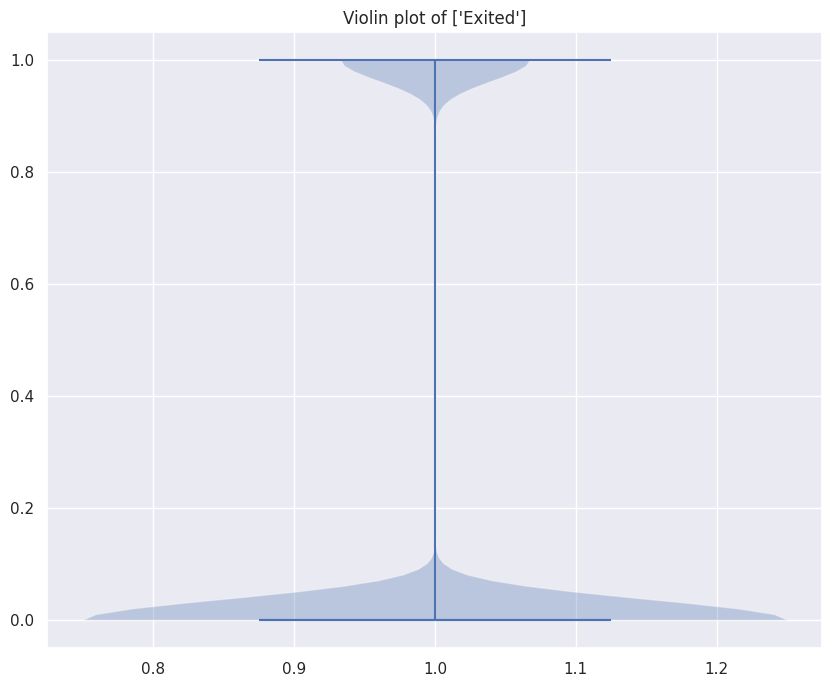

In [41]:
# バイオリンプロット
plt.figure(figsize=(10, 8))
plt.violinplot(target, showmedians=True) # 中央値をマーキングする
plt.title('Violin plot of ' + target_name)
plt.grid(True)

### 特徴量の重要度評価

CPU times: user 4.11 s, sys: 578 ms, total: 4.69 s
Wall time: 2 s


<Axes: >

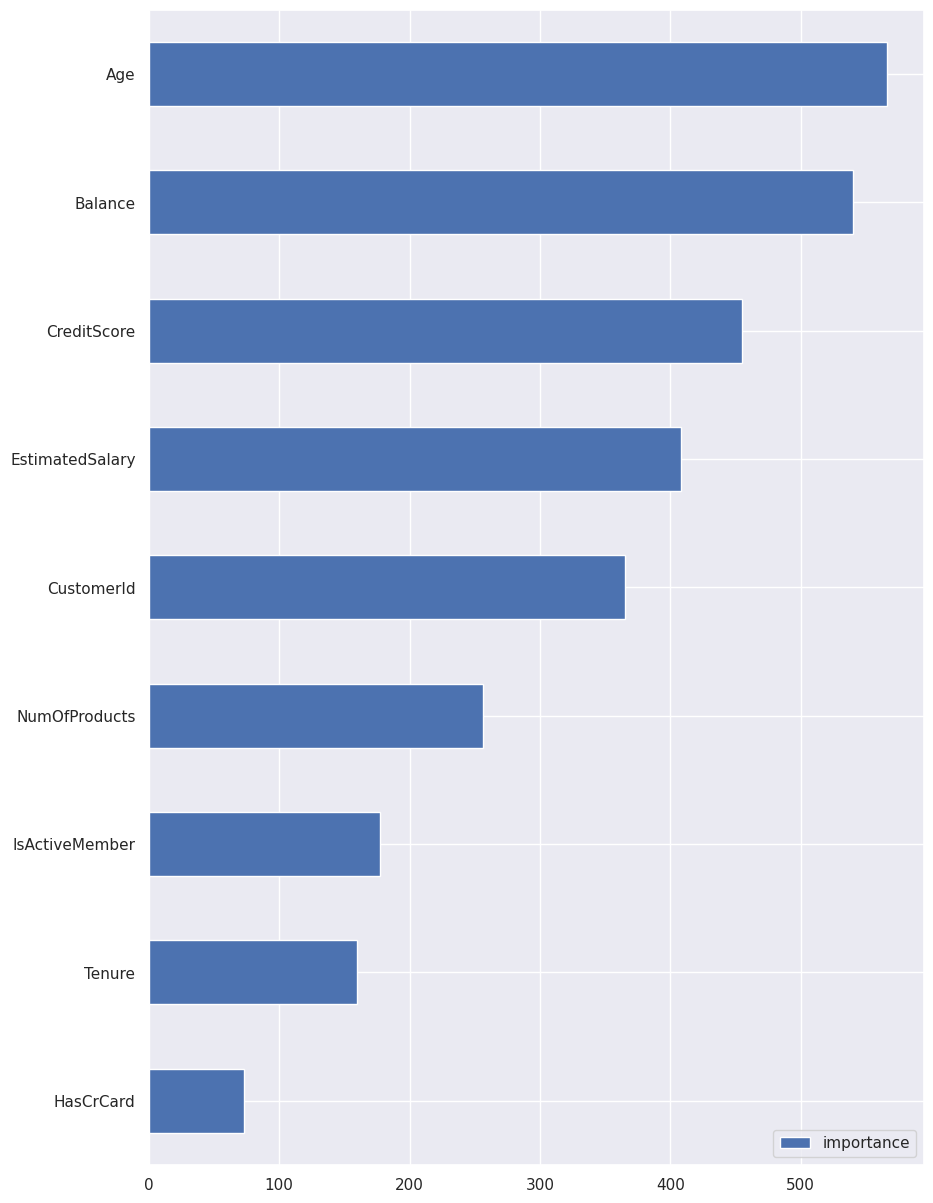

In [42]:
%%time

lgb = LGBMClassifier(
    random_state=42,
)

lgb.fit(X, y)
importance = lgb.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(10, 15), color='b')

In [43]:
feature_importance

,importance
HasCrCard,73
Tenure,160
IsActiveMember,177
NumOfProducts,256
CustomerId,365
EstimatedSalary,408
CreditScore,455
Balance,540
Age,566


* 'Gtp'が重要度が特に高い
* 'hearing(right, left)'が低い

### 相関（ヒートマップ）

<Axes: >

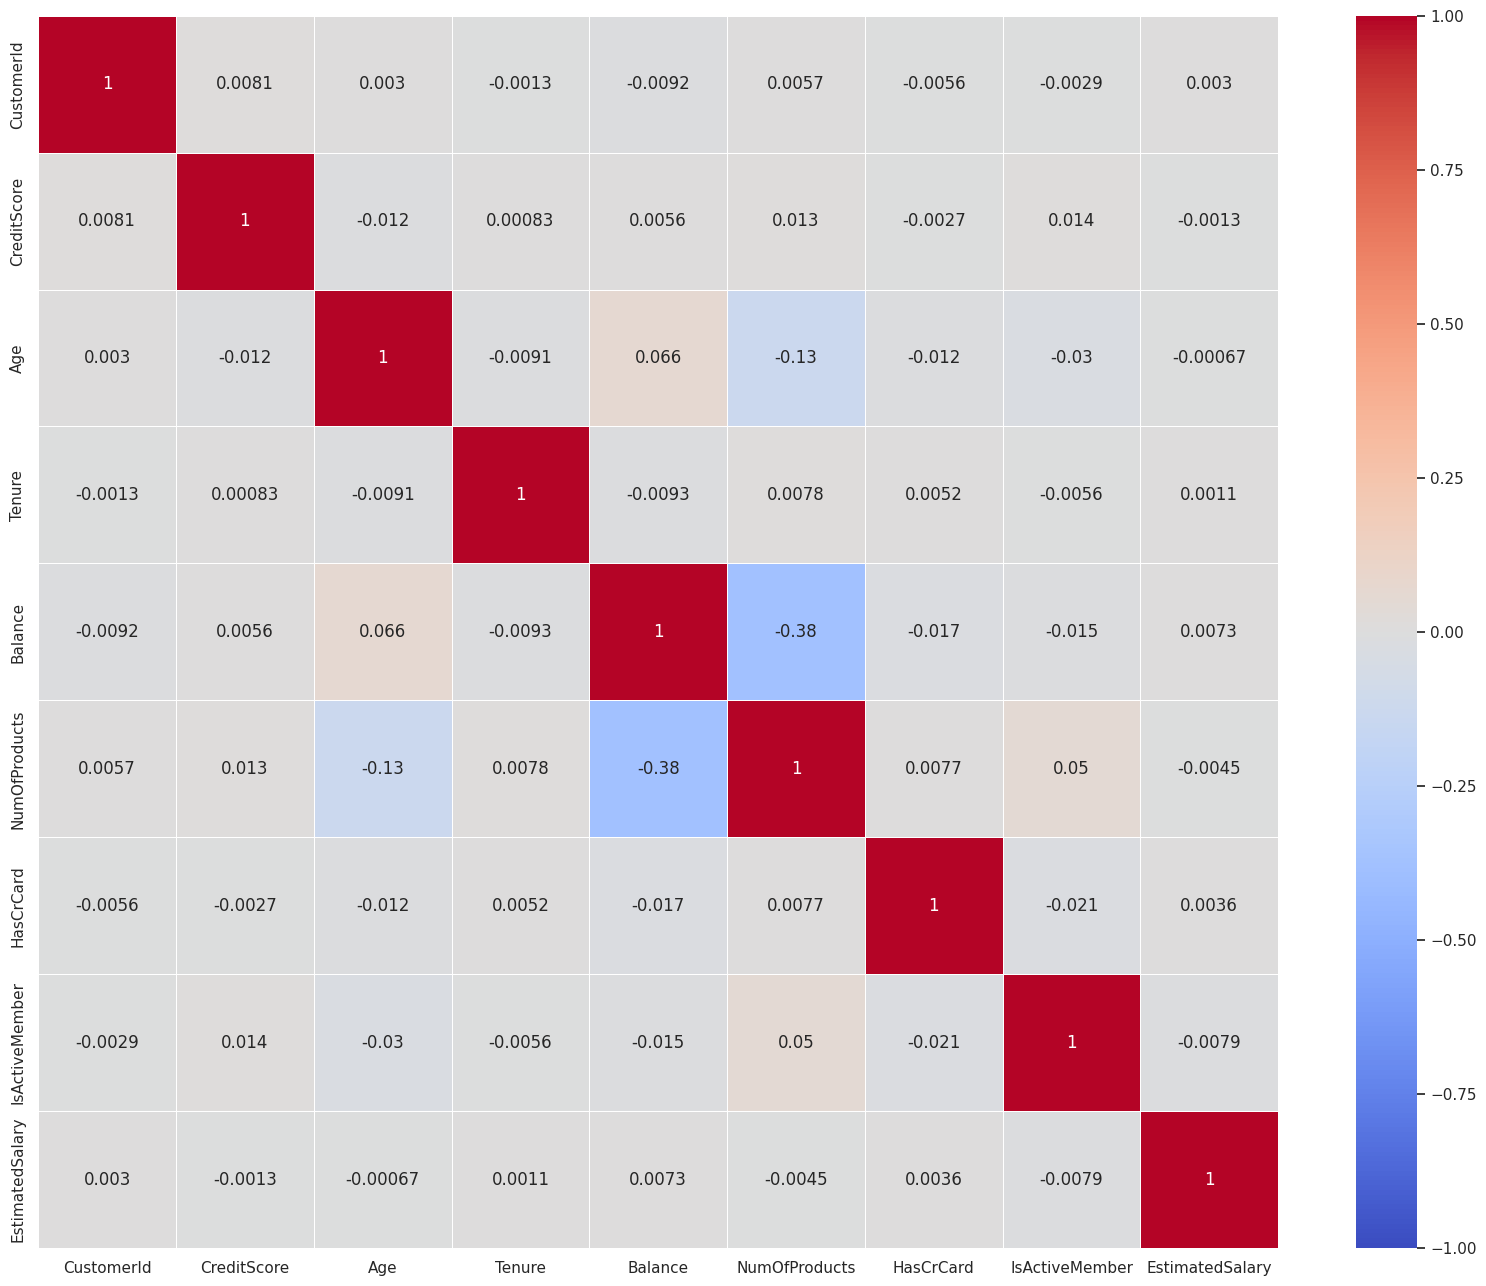

In [44]:
corr = train[numerical_features].corr(method='spearman')
plt.figure()
sns.heatmap(corr, linewidth=0.5, square=False, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

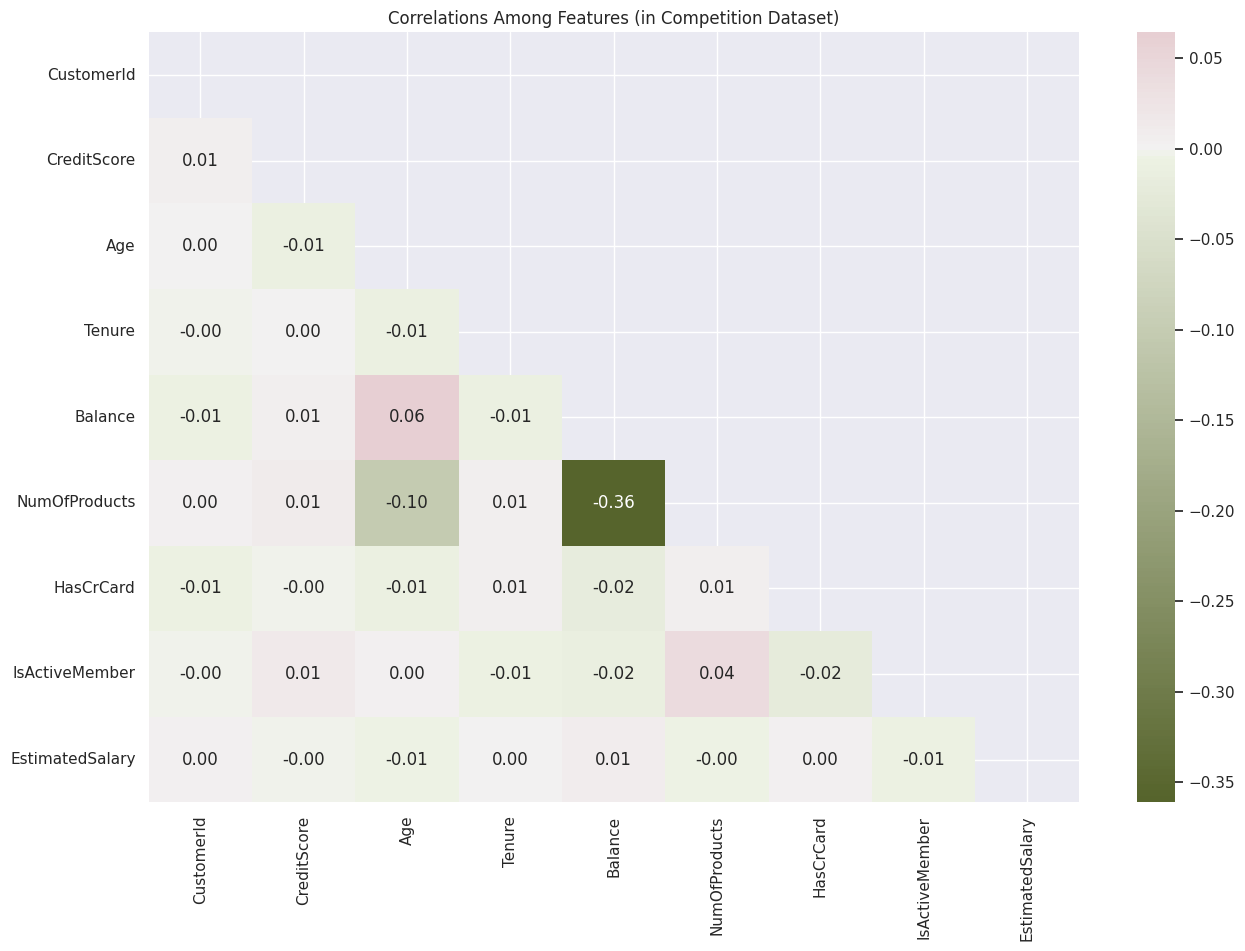

In [45]:
corr_mat_data = train[numerical_features].corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype=bool))

cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center='light', as_cmap=True)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat_data, annot=True, cmap=cmap, fmt='.2f', center=0,
            annot_kws={'size': 12}, mask=data_mask).set_title('Correlations Among Features (in Competition Dataset)');

### 階層的クラスタリング

- 特徴間の関係の強さと方向性を調べる
- 特徴をクラスタリングする

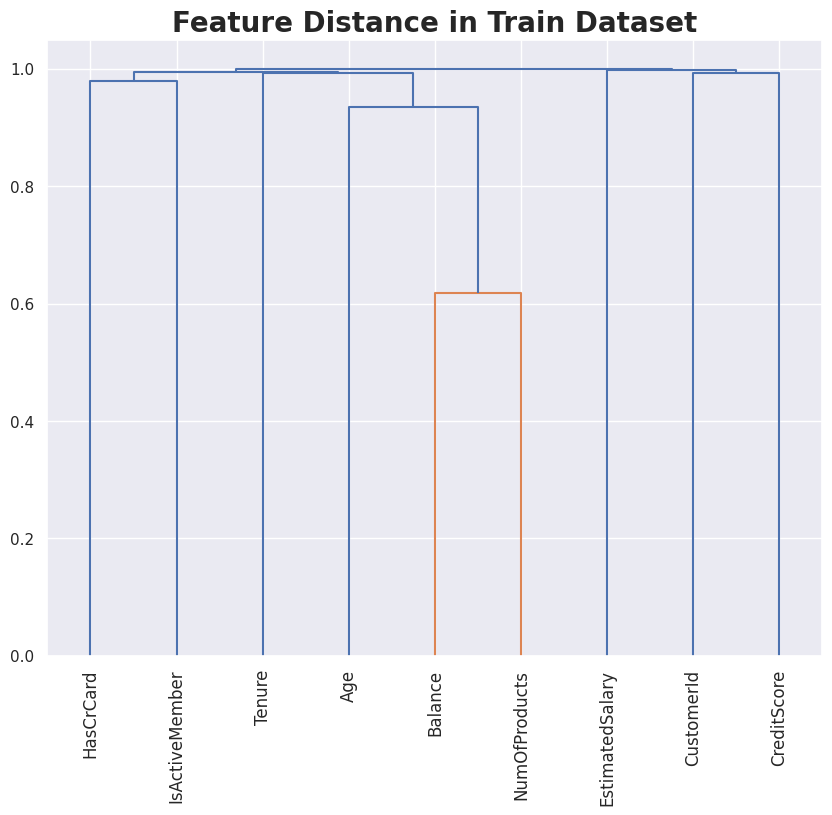

In [46]:
def distance(data, label = ''):
    corr = data.corr(method='spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')

    plt.figure(figsize=(10, 8))
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight='bold', size=20)
    plt.show()

distance(train[numerical_features], 'Train')

## EDAの可視化するためのライブラリ

In [47]:
report = sv.compare([train, "Train"], [test, "Test"], target_feat='Exited')
report.show_html(OUTPUT_DIR + "/EDA_sweetviz.html")

                                             |          | [  0%]   00:00 -> (? left)

Report /kaggle/working//EDA_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 実行時間を調べるために使う

In [48]:
end_time = time.time()
lap = end_time - start_time
indi_time = changeHMS(lap)
indi_time

'3m15s'